# Event-Scale Characteristics and Drivers of Cold Air Outbreaks over the Great Lakes

Haley Schmidt 

ATMS 596 Capstone Project

## Setup 

In [ ]:
# Setup and load required libraries
import xarray as xr 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from numpy.random import default_rng
from scipy.stats import pearsonr
import statsmodels.api as sm
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.stats import linregress
import matplotlib.patches as mpatches
import os, glob
import geopandas as gpd
from shapely.ops import unary_union
from shapely.vectorized import contains


In [11]:
# SSL setup
# Dissable SSL verification
import os, ssl, certifi

# Restore the default HTTPS context
ssl._create_default_https_context = ssl.create_default_context

# Direct OpenSSL to CA certs
os.environ["SSL_CERT_FILE"] = certifi.where()

# custom default context using certifi
def _certifi_context(*args, **kwargs):
    return ssl.create_default_context(cafile=certifi.where(), *args, **kwargs)

ssl._create_default_https_context = _certifi_context

## Load and Preprocess ERA5 Data

#### Load Temperature (t2m) Data

In [ ]:
# t2m file path
t2m_path = 'data/t2m.grib'

# Open GRIB file as an xr Dataset
t2m_data = xr.open_dataset(t2m_path, engine='cfgrib')

# temp values as np
temp_data = t2m_data['t2m']
temp_values = temp_data.values

# coords
units = temp_data.units

# Normalize time
# t2m_data = t2m_data.rename(valid_time="time")
t2m_data = t2m_data.sortby("time")
t2m_data["time"] = xr.decode_cf(t2m_data).time

# Great Lakes domain 
lat_min, lat_max = 41.0, 49.0
lon_min, lon_max = -95.0, -75.0

# Select great lakes domain
t2m_gl = t2m_data.sel(latitude=slice(lat_max, lat_min), 
               longitude=slice(lon_min, lon_max))
t2m_gl

# Convert Kelvin to C
t2m_gl = t2m_gl - 273.15

# Monthly means
t2m_mon = t2m_gl.resample(time="MS").mean()

# Baseline period (1981–2010)
t2m_baseline = t2m_mon.sel(time=slice("1981-01-01", "2010-12-31"))

# Monthly climatology - mean for each month, at every gridpoint
t2m_clim = t2m_baseline.groupby("time.month").mean("time")

# Anomalies
t2m_anom = t2m_mon.groupby("time.month") - t2m_clim

# Area-weighted mean over lat/lon 
weights = np.cos(np.deg2rad(t2m_gl.latitude))
t2m_area = t2m_gl.t2m.weighted(weights).mean(dim=("latitude", "longitude"))

# DJF seasonal means 
t2m_djf = t2m_area.resample(time="QS-DEC").mean()
t2m_djf = t2m_djf.where(t2m_djf["time"].dt.month == 12, drop=True)

# season_year index
season_year = (t2m_djf["time"].dt.year + 1).to_index()
t2m_djf = pd.Series(t2m_djf.values, index=season_year, name="t2m_DJF")   

# Extract DataArray 
t2m = t2m_gl['t2m']

# Daily means 
t2m_d = t2m.resample(time='1D').mean()

# Only DJF days
is_djf = t2m_d['time'].dt.month.isin([12, 1, 2])
t2m_djf_daily = t2m_d.where(is_djf, drop=True)


Ignoring index file '/Users/Haley/Desktop/Capstone-2/great_lakes_capstone_2/data/t2m.grib.5b7b6.idx' older than GRIB file


#### Load Mean Sea Level Pressure (msl) Data

In [ ]:
# msl file path
msl_path = 'data/msl.grib'

# Open GRIB file as an xr Dataset
msl_data = xr.open_dataset(msl_path, engine='cfgrib')

# temp values as np
press_data = msl_data['msl']
press_values = press_data.values

# coords
press_units = press_data.units

# Normalize time
# msl_data = msl_data.rename(valid_time="time")
msl_data = msl_data.sortby("time")
msl_data["time"] = xr.decode_cf(msl_data).time

# Great Lakes domain 
lat_min, lat_max = 41.0, 49.0
lon_min, lon_max = -95.0, -75.0

# Select great lakes domain
msl_gl = msl_data.sel(latitude=slice(lat_max, lat_min), 
               longitude=slice(lon_min, lon_max))
msl_gl

# Convert Pa to hPa
msl_gl = msl_gl/100

# Monthly means
msl_mon = msl_gl.resample(time="MS").mean()

# Baseline period (1981–2010)
msl_baseline = msl_mon.sel(time=slice("1981-01-01", "2010-12-31"))

# Monthly climatology - mean for each month, at every gridpoint
msl_clim = msl_baseline.groupby("time.month").mean("time")

# Anomalies
msl_anom = msl_mon.groupby("time.month") - msl_clim

# Area-weighted mean over lat/lon 
weights = np.cos(np.deg2rad(msl_gl.latitude))
msl_area = msl_gl.msl.weighted(weights).mean(dim=("latitude", "longitude"))

# DJF seasonal means 
msl_djf = msl_area.resample(time="QS-DEC").mean()
msl_djf = msl_djf.where(msl_djf["time"].dt.month == 12, drop=True)

# season_year index
season_year = (msl_djf["time"].dt.year + 1).to_index()
msl_djf = pd.Series(msl_djf.values, index=season_year, name="msl_DJF")    


Ignoring index file '/Users/Haley/Desktop/Capstone-2/great_lakes_capstone_2/data/msl.grib.5b7b6.idx' older than GRIB file


#### Load 500-hPa Geopotential Height (z500) Data

In [ ]:
# z500 file path
z500_path = "data/z500.grib"

# open Grib as XR
z500_ds = xr.open_dataset(z500_path, engine="cfgrib")

zvar_name = list(z500_ds.data_vars)[0]
z500 = z500_ds[zvar_name].sortby("time")

# Great Lakes domain
lat_min, lat_max = 41.0, 49.0
lon_min, lon_max = -95.0, -75.0
z500_gl = z500.sel(latitude=slice(lat_max, lat_min),
                   longitude=slice(lon_min, lon_max))

# convert m^2 s^-2 to m
if ("units" in z500_gl.attrs and "m**2 s**-2" in z500_gl.attrs["units"]) or z500_gl.max() > 1e4:
    z500_gl = z500_gl / 9.80665
    z500_gl.attrs["units"] = "m"

# subset DJF
z500_d = z500_gl.resample(time="1D").mean()
is_djf_z = z500_d["time"].dt.month.isin([12, 1, 2])
z500_djf_daily = z500_d.where(is_djf_z, drop=True)

# monthly climatology 1981–2010
z500_mon = z500_gl.resample(time="MS").mean()
z500_base = z500_mon.sel(time=slice("1981-01-01", "2010-12-31"))
z500_clim_mon = z500_base.groupby("time.month").mean("time")  # (month, lat, lon)

z500_djf_anom = z500_djf_daily.groupby("time.month") - z500_clim_mon

# Align z500_djf_anom with t2m_djf_daily 
common_time = np.intersect1d(z500_djf_anom.time.values, t2m_djf_daily.time.values)
z500_djf_anom = z500_djf_anom.sel(time=common_time)
t2m_djf_daily_aligned = t2m_djf_daily.sel(time=common_time)


Ignoring index file '/Users/Haley/Desktop/Capstone-2/great_lakes_capstone_2/data/z500.grib.5b7b6.idx' older than GRIB file


## CAO Detection and Metrics

In [15]:
# Extract array 
t2m = t2m_gl['t2m']
t2m = t2m.sortby('time')

# Daily means 
t2m_d = t2m.resample(time='1D').mean()

# Only DJF days
is_djf = t2m_d['time'].dt.month.isin([12, 1, 2])
t2m_djf_daily = t2m_d.where(is_djf, drop=True)

# Build season_year
season_year = xr.DataArray(
    (t2m_djf_daily['time'].dt.year + (t2m_djf_daily['time'].dt.month == 12).astype(int)).values,
    coords={'time': t2m_djf_daily['time']}, dims=['time'], name='season_year'
)
t2m_djf_daily = t2m_djf_daily.assign_coords(season_year=season_year)

# 5th percentile threshold 
thr = t2m_djf_daily.quantile(0.05, dim='time')  

# Boolean mask of cold days 
cold_mask = t2m_djf_daily < thr
mask_int = cold_mask.astype(int)

# Count consecutive cold days 
streak = xr.zeros_like(mask_int)
count = xr.zeros_like(mask_int.isel(time=0))
for t in range(mask_int.sizes['time']):
    is_cold = mask_int.isel(time=t)
    count = (count + 1) * is_cold
    streak[t] = count

cold_events = streak >= 3    

# Area weighted regional fraction of cold event coverage each day
weights = np.cos(np.deg2rad(cold_events.latitude))
regional_frac = cold_events.weighted(weights).mean(dim=('latitude', 'longitude'))  

# Define regional CAO day 
regional_cao_day = (regional_frac > 0.0)  
regional_cao_day = regional_cao_day.assign_coords(season_year=season_year)

# Collapse CAO days into events
run_labels = (regional_cao_day != regional_cao_day.shift(time=1)).cumsum(dim='time')

# Build an event table
events = []
for lab, grp in regional_cao_day.groupby(run_labels):
    if bool(grp.isel(time=0)):  
        sy = int(grp['season_year'].isel(time=0).values)
        start = pd.to_datetime(grp['time'].values[0])
        end   = pd.to_datetime(grp['time'].values[-1])
        dur   = (end - start).days + 1
        # event intensity and spatial extent 
        # mean regional coverage
        cov_mean = float(regional_frac.sel(time=grp['time']).mean().values)
        # mean t2m anomaly 
        t2m_below = (t2m_djf_daily.sel(time=grp['time']) - thr).where(cold_events.sel(time=grp['time']))
        if t2m_below.notnull().any():
            t2m_below_reg = t2m_below.weighted(weights).mean(('latitude','longitude')).mean('time').item()
        else:
            t2m_below_reg = np.nan

        events.append(dict(season_year=sy, start=start, end=end, duration_days=dur,
                           regional_coverage_mean=cov_mean, mean_temp_below_thr=float(t2m_below_reg)))

events_df = pd.DataFrame(events).sort_values(['season_year', 'start']).reset_index(drop=True)

# Number of CAO events per season-year
events_per_season = (events_df.groupby('season_year')
                                 .size()
                                 .rename('n_events')
                                 .to_frame())

# Number of CAO days per season-year 
cao_days_per_season = (regional_cao_day.groupby('season_year')
                                      .sum(dim='time')
                                      .to_pandas()
                                      .rename('cao_days'))

# Area-weighted mean daily coverage per season-year
coverage_per_season = (regional_frac.groupby(season_year)
                                     .mean('time')
                                     .to_pandas()
                                     .rename('mean_daily_coverage'))

# Join summaries
cao_summary = (events_per_season
               .join(cao_days_per_season, how='outer')
               .join(coverage_per_season, how='outer')
               .fillna(0)
               .sort_index())

print(cao_summary.head())
print(events_df.head())

             n_events  cao_days  mean_daily_coverage
season_year                                         
1940              3.0        10             0.005857
1941              3.0         4             0.000874
1942              5.0        15             0.005760
1943              5.0        14             0.002119
1944              2.0         2             0.000047
   season_year      start        end  duration_days  regional_coverage_mean  \
0         1940 1940-01-18 1940-01-20              3                0.060177   
1         1940 1940-01-24 1940-01-29              6                0.028415   
2         1940 1940-02-15 1940-02-15              1                0.000383   
3         1941 1941-02-05 1941-02-05              1                0.032076   
4         1941 1941-02-20 1941-02-21              2                0.021928   

   mean_temp_below_thr  
0            -2.862453  
1            -2.303093  
2            -1.983337  
3            -1.360371  
4            -1.741793  


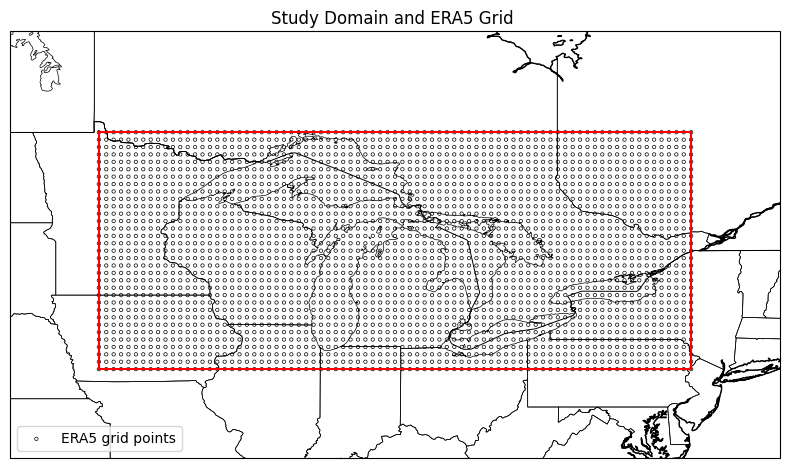

In [ ]:
# Study Domain Plot with ERA5 Grid
da = cold_events  

lat = da.latitude
lon = da.longitude

# Domain bounds 
lat_min, lat_max = 41.0, 49.0
lon_min, lon_max = -95.0, -75.0

# 2D grid of points 
lon2d, lat2d = np.meshgrid(lon, lat)

fig = plt.figure(figsize=(8, 5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon_min - 3, lon_max + 3, lat_min - 3, lat_max + 3])
ax.coastlines()
ax.add_feature(cfeature.STATES, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.7)

# plot ERA5 grid points
ax.scatter(
    lon2d,
    lat2d,
    s=6,
    marker="o",
    facecolor="none",
    edgecolor="k",
    linewidth=0.5,
    transform=ccrs.PlateCarree(),
    label="ERA5 grid points",
)
rect = mpatches.Rectangle(
    (lon_min, lat_min),               
    lon_max - lon_min,                
    lat_max - lat_min,               
    linewidth=1.5,
    edgecolor="red",
    facecolor="none",
    transform=ccrs.PlateCarree(),
    zorder=5,
)
ax.add_patch(rect)
ax.set_title("Study Domain and ERA5 Grid ")
ax.legend(loc="lower left")

plt.tight_layout()
plt.savefig("code/figures/study_domain_map.png", dpi=300, bbox_inches="tight")
plt.show()



## CAO Climatology & Trends

CAO frequency (min, max): 0.0012934937265554262 0.01332298538352089


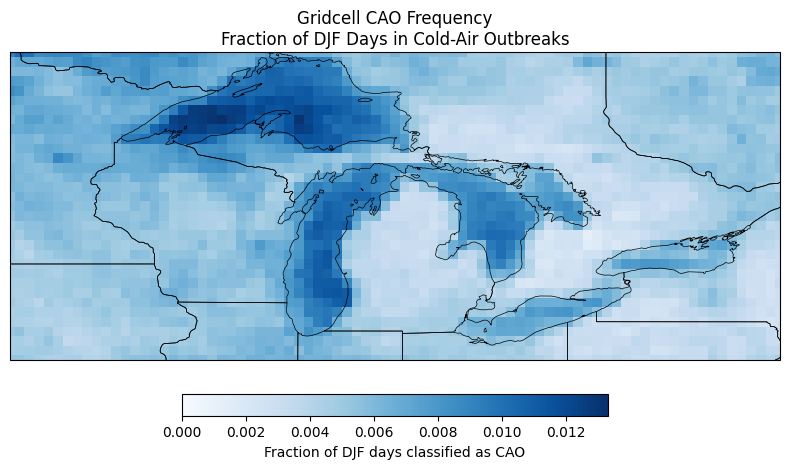

In [ ]:
# Gridcell CAO Frequency Map - fraction of DJF days classified as CAOs at each grid cell
cao_freq_cell = cold_events.astype(float).mean(dim="time")
cao_freq_cell.name = "cao_freq"

print("CAO frequency (min, max):",
      float(cao_freq_cell.min()), float(cao_freq_cell.max()))

# Plot
fig = plt.figure(figsize=(8, 5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon_min, lon_max, lat_min, lat_max])
im = cao_freq_cell.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap="Blues",
    vmin=0.0,
    vmax=float(cao_freq_cell.max()),
    cbar_kwargs={
        "label": "Fraction of DJF days classified as CAO",
        "orientation": "horizontal",
        "pad": 0.08,        
        "fraction": 0.05 
    },
)
ax.coastlines()
ax.add_feature(cfeature.STATES, linewidth=0.5)
ax.set_title("Gridcell CAO Frequency\nFraction of DJF Days in Cold-Air Outbreaks")
plt.tight_layout()
plt.savefig("code/figures/gridcell_cao_freq_map.png", dpi=300, bbox_inches="tight")
plt.show()



Trend range (days/decade): -0.21604792678899654 to 0.10085381385914381


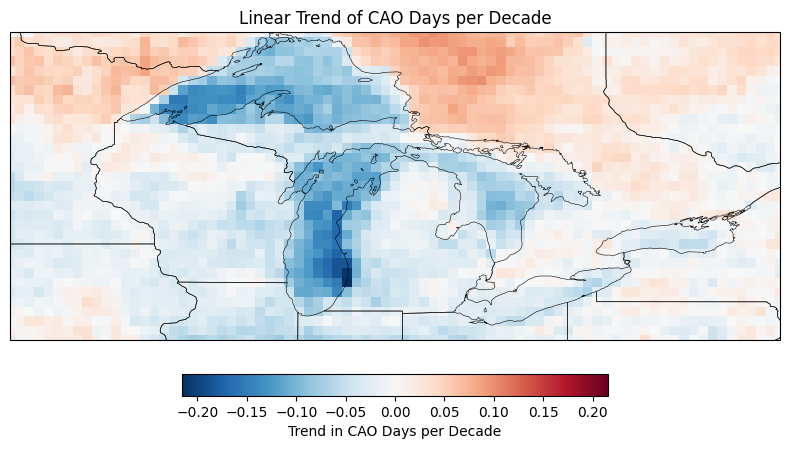

In [ ]:
# Gridcell CAO trend days per decade

# Count CAO days per gridcell 
cao_days_gridcell = (
    cold_events.astype(int)
               .groupby(season_year)
               .sum("time")     
)  

years = cao_days_gridcell["season_year"].values.astype(float)

# Compute linear trend 
trend = xr.apply_ufunc(
    lambda y: np.polyfit(years, y, 1)[0] * 10, 
    cao_days_gridcell,
    input_core_dims=[["season_year"]],
    vectorize=True,
    dask="parallelized",
    output_dtypes=[float],
)

trend = trend.rename("cao_trend_days_per_decade")

print("Trend range (days/decade):",
      float(trend.min()), "to", float(trend.max()))

#Plot
fig = plt.figure(figsize=(8, 5))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([lon_min, lon_max, lat_min, lat_max])
ax.coastlines()
ax.add_feature(cfeature.STATES, linewidth=0.4)
vlim = np.nanmax(np.abs(trend.values))

im = trend.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap="RdBu_r",
    vmin=-vlim,
    vmax= vlim,
    cbar_kwargs={"label": "Trend in CAO Days per Decade",
        "orientation": "horizontal",
        "pad": 0.08,        
        "fraction": 0.05 },
)

ax.set_title("Linear Trend of CAO Days per Decade")
plt.tight_layout()
plt.savefig("code/figures/cao_days_per_decade_map.png", dpi=300, bbox_inches="tight")
plt.show()


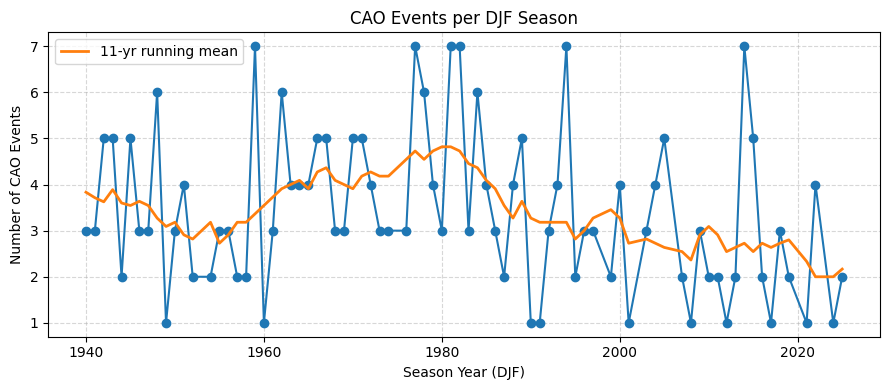

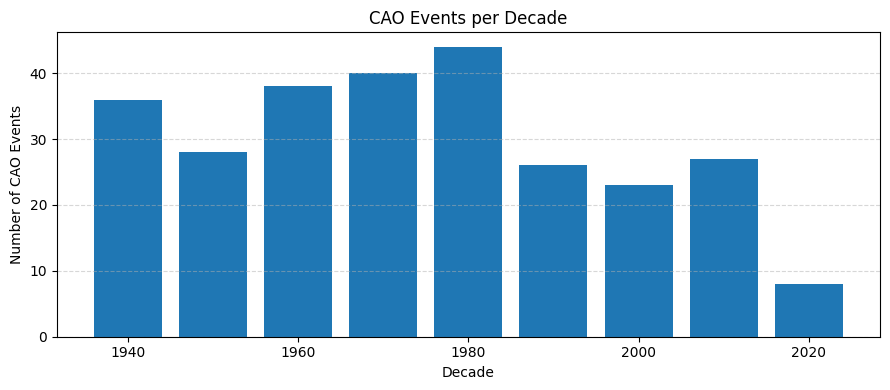

season_year
1940    36
1950    28
1960    38
1970    40
1980    44
1990    26
2000    23
2010    27
2020     8
Name: n_events_decade, dtype: int64

In [ ]:
# Counts of CAO events per season and decade plots
cao_events_per_season = (
    events_df.groupby("season_year")
             .size()
             .rename("n_events")
)

cao_events_per_season.head()

# Plot time series of CAO events per DJF season
series = cao_events_per_season.sort_index()

# 11 year running mean
series_smooth = series.rolling(window=11, center=True, min_periods=3).mean()

plt.figure(figsize=(9,4))
plt.plot(series.index, series.values, marker="o")
plt.plot(
    series_smooth.index,
    series_smooth.values,
    linewidth=2,
    label="11-yr running mean",
)
plt.xlabel("Season Year (DJF)")
plt.ylabel("Number of CAO Events")
plt.title("CAO Events per DJF Season")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig("code/figures/cao_counts_timeseries.png", dpi=300, bbox_inches="tight")
plt.show()

# Plot decadal counts 
decade = (series.index // 10) * 10
cao_events_decadal = (
    series.groupby(decade)
          .sum()
          .rename("n_events_decade")
)

plt.figure(figsize=(9,4))
plt.bar(cao_events_decadal.index, cao_events_decadal.values, width=8)
plt.xlabel("Decade")
plt.ylabel("Number of CAO Events")
plt.title("CAO Events per Decade")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig("code/figures/cao_counts_decade.png", dpi=300, bbox_inches="tight")
plt.show()

cao_events_decadal


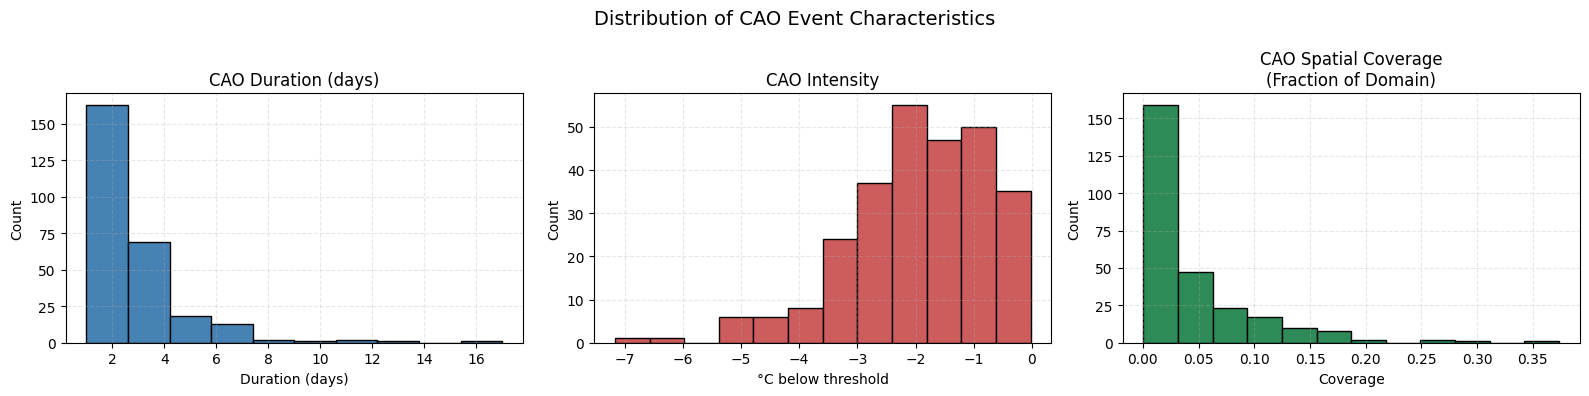

In [ ]:
# Histograms of CAO Metrics 
# Duration, Intensity, Coverage

dur = events_df["duration_days"]
intensity = events_df["mean_temp_below_thr"]   # negative values = stronger CAOs
coverage = events_df["regional_coverage_mean"] 

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Duration
axes[0].hist(dur, bins=10, color="steelblue", edgecolor="k")
axes[0].set_title("CAO Duration (days)")
axes[0].set_xlabel("Duration (days)")
axes[0].set_ylabel("Count")
axes[0].grid(alpha=0.3, linestyle="--")

# Intensity
axes[1].hist(intensity, bins=12, color="indianred", edgecolor="k")
axes[1].set_title("CAO Intensity")
axes[1].set_xlabel("°C below threshold")
axes[1].set_ylabel("Count")
axes[1].grid(alpha=0.3, linestyle="--")

# Spatial Coverage
axes[2].hist(coverage, bins=12, color="seagreen", edgecolor="k")
axes[2].set_title("CAO Spatial Coverage\n(Fraction of Domain)")
axes[2].set_xlabel("Coverage")
axes[2].set_ylabel("Count")
axes[2].grid(alpha=0.3, linestyle="--")

plt.suptitle("Distribution of CAO Event Characteristics", fontsize=14)
plt.tight_layout()
plt.savefig("ode/figures/cao_metrics_histogram.png", dpi=300, bbox_inches="tight")
plt.show()


In [ ]:
# Man kendall and sen slope function
def mann_kendall_sen_slope(series):
    y = series.dropna().values
    n = len(y)
    if n < 3:
        raise ValueError("cannotMann-Kendall")

    # Mann-Kendall statistic
    S = 0
    for i in range(n-1):
        S += np.sign(y[i+1:] - y[i]).sum()
    
    # Variance 
    var_S = (n*(n-1)*(2*n+5)) / 18.0
    z = S / np.sqrt(var_S) if S != 0 else 0.0
    
    # two-sided p 
    from scipy.stats import norm
    p = 2 * (1 - norm.cdf(abs(z)))
    
    # tau 
    tau = S / (0.5 * n * (n-1))

    # Sen's slope
    slopes = []
    for i in range(n-1):
        slopes.extend((y[j] - y[i]) / (j - i) for j in range(i+1, n))
    sen = np.median(slopes)

    return {"tau": tau, "p_value": p, "sen_slope": sen}

# Print mk results for events per year and events per decade
mk_result = mann_kendall_sen_slope(cao_events_per_season)
print("Mann-Kendall tau:", mk_result["tau"])
print("p-value:", mk_result["p_value"])
print("Sen's slope (events per year):", mk_result["sen_slope"])
print("Sen's slope (events per decade):", mk_result["sen_slope"]*10)

Mann-Kendall tau: -0.16098669263226226
p-value: 0.035752672805452246
Sen's slope (events per year): 0.0
Sen's slope (events per decade): 0.0


Seasonal CAO statistics:


mean_duration_days  mean_intensity_degC
season_year                                         
1940                   3.333333            -2.382961
1941                   1.333333            -1.688588
1942                   3.000000            -2.151804
1943                   2.800000            -1.920862
1944                   1.000000            -1.168450

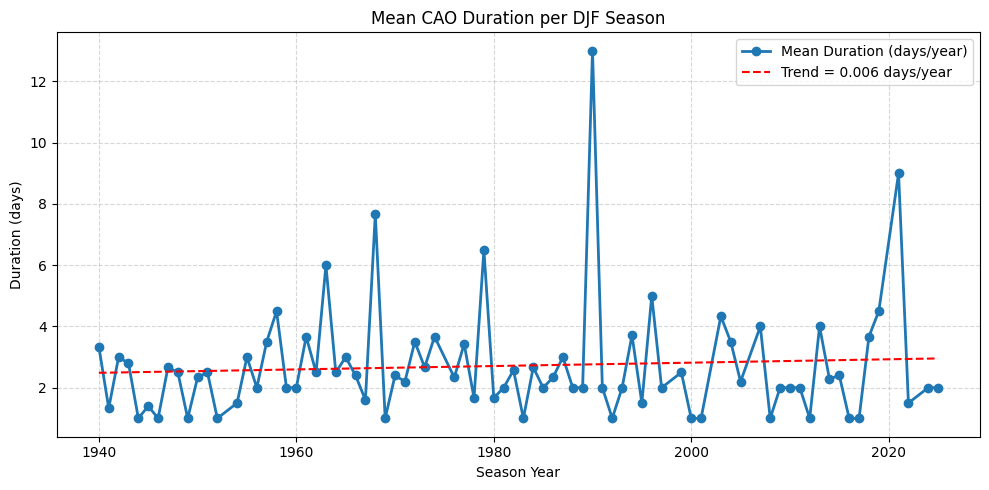

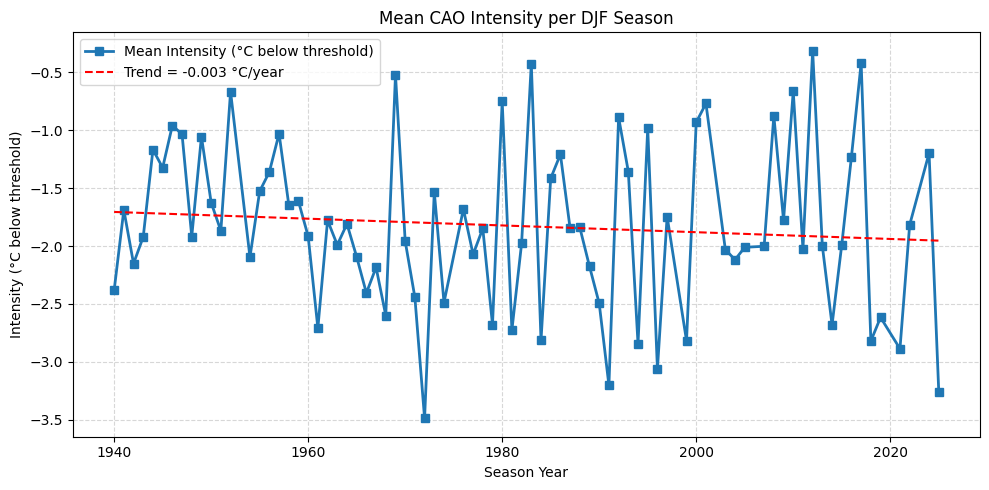

In [ ]:
# CAO Duration & Intensity Time Series
events_df["season_year"] = events_df["season_year"].astype(int)

# Mean duration per DJF season
mean_duration = (
    events_df.groupby("season_year")["duration_days"]
             .mean()
             .rename("mean_duration_days")
)

# Mean intensity per DJF season 
# negative = stronger CAO
mean_intensity = (
    events_df.groupby("season_year")["mean_temp_below_thr"]
             .mean()
             .rename("mean_intensity_degC")
)

cao_seasonal_stats = pd.concat([mean_duration, mean_intensity], axis=1)

print("Seasonal CAO statistics:")
display(cao_seasonal_stats.head())

# Plot Mean Duration Time Series
plt.figure(figsize=(10,5))
plt.plot(mean_duration.index, mean_duration.values,
         marker="o", label="Mean Duration (days/year)", linewidth=2)

# Add linear trend
years = mean_duration.index.values.astype(float)
dur_slope, dur_intercept = np.polyfit(years, mean_duration.values, 1)
plt.plot(mean_duration.index,
         dur_slope * years + dur_intercept,
         linestyle="--", color="red",
         label=f"Trend = {dur_slope:.3f} days/year")

plt.title("Mean CAO Duration per DJF Season")
plt.xlabel("Season Year")
plt.ylabel("Duration (days)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig("code/figures/mean_duration_timeseries.png", dpi=300, bbox_inches="tight")
plt.show()

# Plot Mean Intensity Time Series
plt.figure(figsize=(10,5))
plt.plot(mean_intensity.index, mean_intensity.values,
         marker="s", label="Mean Intensity (°C below threshold)", linewidth=2)

# Linear trend
years = mean_intensity.index.values.astype(float)
int_slope, int_intercept = np.polyfit(years, mean_intensity.values, 1)
plt.plot(mean_intensity.index,
         int_slope * years + int_intercept,
         linestyle="--", color="red",
         label=f"Trend = {int_slope:.3f} °C/year")

plt.title("Mean CAO Intensity per DJF Season")
plt.xlabel("Season Year")
plt.ylabel("Intensity (°C below threshold)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig("code/figures/mean_duration_timeseries.png", dpi=300, bbox_inches="tight")
plt.show()


## Import Teleconnection Data and Create Leads

In [ ]:
# Load teleconnection data

# Teleconnection file paths
files = {
    "ENSO": "data/monthly_enso.xlsx",
    "PDO":  "data/monthly_pdo.xlsx",
    "AO": "data/monthly_ao.xlsx",
    "NAO": "data/monthly_nao.xlsx"
}

# months
MONTH_MAP = {
    "jan":1, "feb":2, "mar":3, "apr":4, "may":5, "jun":6,
    "jul":7, "aug":8, "sep":9, "oct":10, "nov":11, "dec":12
}

# Helper function to clean teleconnection data and convert to long format
def clean_wide_monthly(df, name):
    df = df.copy()
    df.columns = [c.strip() for c in df.columns]
    month_cols = [c for c in df.columns if c.lower() in MONTH_MAP]
    year_col = "Year" if "Year" in df.columns else "year"

    # melt data to long format
    long = df.melt(
        id_vars=[year_col],
        value_vars=month_cols,
        var_name="month_name",
        value_name=name
    )
    long["month"] = long["month_name"].str.lower().map(MONTH_MAP)
    long["time"] = pd.to_datetime(
        dict(year=long[year_col], month=long["month"], day=15)
    )
    long[name] = pd.to_numeric(long[name], errors="coerce")

    out = (
        long[["time", name]]
        .dropna()
        .sort_values("time")
        .set_index("time")
    )
    out = out.loc[(out.index.year >= 1940) & (out.index.year <= 2024)]
    return out

indices = {}
for name, path in files.items():
    df = pd.read_excel(path)
    indices[name] = clean_wide_monthly(df, name)

# Combine all teleconnections to one df
tele_monthly = pd.concat(indices, axis=1).sort_index()
tele_monthly.columns = [c[0] for c in tele_monthly.columns]  

# Convert ENSO to anomalies
enso = tele_monthly["ENSO"].copy()

# Baseline mask and monthly climatology
mask_base = (enso.index.year >= 1981) & (enso.index.year <= 2010)
enso_base = enso[mask_base]
enso_clim = enso_base.groupby(enso_base.index.month).mean()  

# Subtract monthly mean 
m = enso.index.month
enso_anom = enso - enso_clim[m].to_numpy()

tele_monthly["ENSO"] = enso_anom  

# Create monthly leads 
tele = tele_monthly.copy()

for var in ["ENSO", "PDO", "AO", "NAO"]:
    tele[f"{var}_lead0"] = tele[var]          # same month
    tele[f"{var}_lead1"] = tele[var].shift(1) # 1 month lead
    tele[f"{var}_lead2"] = tele[var].shift(2) # 2 month lead

# Build DJF season_year and average the monthly leads 
def month_to_season(m):
    if m in (12, 1, 2): return "DJF"
    if m in (3, 4, 5):  return "MAM"
    if m in (6, 7, 8):  return "JJA"
    return "SON"

tele["season"] = tele.index.month.map(month_to_season)
tele["season_year"] = tele.index.year + (tele.index.month == 12).astype(int)

# Keep only DJF months
tele_djf = tele[tele["season"] == "DJF"].copy()

# DJF mean of the monthly lagged indices 
tele_leads_djf = (
    tele_djf
    .groupby("season_year")
    .mean(numeric_only=True)
    .sort_index()
)

# Merge with seasonal t2m_djf and msl_djf 
if isinstance(t2m_djf, pd.Series):
    t2m_djf = t2m_djf.to_frame(name="t2m_DJF")
else:
    t2m_djf.columns = ["t2m_DJF"]

if isinstance(msl_djf, pd.Series):
    msl_djf = msl_djf.to_frame(name="msl_DJF")
else:
    msl_djf.columns = ["msl_DJF"]

tele_leads_djf.index = tele_leads_djf.index.astype(int)
for df in [t2m_djf, msl_djf, tele_leads_djf]:
    df.index.name = "season_year"

model_basin_df = (
    t2m_djf
    .merge(msl_djf, left_index=True, right_index=True, how="inner")
    .merge(tele_leads_djf, left_index=True, right_index=True, how="inner")
)


## Teleconnection - CAO Relationships

#### Correlation between Teleconnections and CAO events

n_events vs ENSO: r = 0.004, p = 0.977, R² = 0.000
n_events vs PDO: r = 0.322, p = 0.007, R² = 0.104
n_events vs AO: r = -0.077, p = 0.531, R² = 0.006
n_events vs NAO: r = -0.068, p = 0.582, R² = 0.005
n_events vs ENSO_lead0: r = 0.004, p = 0.977, R² = 0.000
n_events vs ENSO_lead1: r = -0.008, p = 0.947, R² = 0.000
n_events vs ENSO_lead2: r = 0.017, p = 0.889, R² = 0.000
n_events vs PDO_lead0: r = 0.322, p = 0.007, R² = 0.104
n_events vs PDO_lead1: r = 0.332, p = 0.006, R² = 0.111
n_events vs PDO_lead2: r = 0.314, p = 0.009, R² = 0.098
n_events vs AO_lead0: r = -0.077, p = 0.531, R² = 0.006
n_events vs AO_lead1: r = -0.091, p = 0.461, R² = 0.008
n_events vs AO_lead2: r = -0.109, p = 0.374, R² = 0.012
n_events vs NAO_lead0: r = -0.068, p = 0.582, R² = 0.005
n_events vs NAO_lead1: r = -0.091, p = 0.458, R² = 0.008
n_events vs NAO_lead2: r = -0.146, p = 0.234, R² = 0.021
ENSO-CAO correlations by lead:
   lead         r         p        R2
0     0 -0.001471  0.989736  0.000002
1     1 -0.0

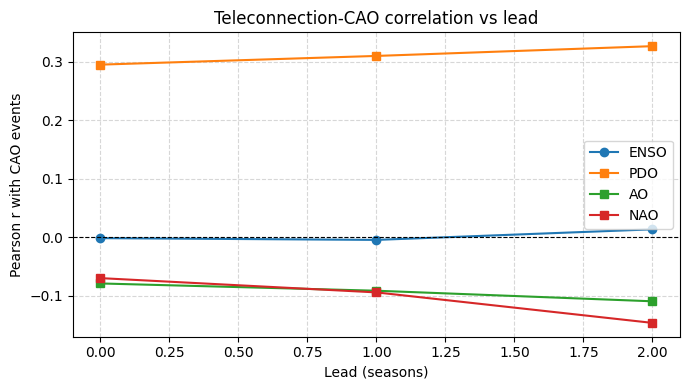

In [ ]:
# Build combined df of cao events per season and teleconnection leads
df_tele_cao = pd.concat(
    [cao_events_per_season.rename("n_events"), tele_leads_djf],
    axis=1
).dropna()

df_tele_cao.head()

# pearson r for each indices
for col in df_tele_cao.columns:
    if col.startswith(("ENSO", "PDO", "AO", "NAO")):
        r, p = pearsonr(df_tele_cao["n_events"], df_tele_cao[col])
        print(f"n_events vs {col}: r = {r:.3f}, p = {p:.3f}, R² = {r**2:.3f}")

# compute correlation by lead 
def corr_by_lead(metric_series, tele_df, base_name="ENSO", max_lead=2):
    out = []
    for L in range(0, max_lead+1):
        col = f"{base_name}_lead{L}"
        if col not in tele_df.columns:
            continue
        df_tmp = pd.concat([metric_series.rename("metric"), tele_df[col]], axis=1).dropna()
        r, p = pearsonr(df_tmp["metric"], df_tmp[col])
        out.append({"lead": L, "r": r, "p": p, "R2": r**2})
    return pd.DataFrame(out)

# correlation for each index with cao events
enso_corr = corr_by_lead(cao_events_per_season, tele_leads_djf, base_name="ENSO", max_lead=2)
pdo_corr  = corr_by_lead(cao_events_per_season, tele_leads_djf, base_name="PDO",  max_lead=2)
ao_corr  = corr_by_lead(cao_events_per_season, tele_leads_djf, base_name="AO",  max_lead=2)
nao_corr  = corr_by_lead(cao_events_per_season, tele_leads_djf, base_name="NAO",  max_lead=2)

# print results
print("ENSO-CAO correlations by lead:")
print(enso_corr)

print("\nPDO-CAO correlations by lead:")
print(pdo_corr)

print("\nAO-CAO correlations by lead:")
print(ao_corr)

print("\nNAO-CAO correlations by lead:")
print(nao_corr)

# plot teleconnection lead - cao correlation
plt.figure(figsize=(7,4))
plt.plot(enso_corr["lead"], enso_corr["r"], marker="o", label="ENSO")
plt.plot(pdo_corr["lead"],  pdo_corr["r"],  marker="s", label="PDO")
plt.plot(ao_corr["lead"],  ao_corr["r"],  marker="s", label="AO")
plt.plot(nao_corr["lead"],  nao_corr["r"],  marker="s", label="NAO")
plt.axhline(0, color="k", linestyle="--", linewidth=0.8)
plt.xlabel("Lead (seasons)")
plt.ylabel("Pearson r with CAO events")
plt.title("Teleconnection-CAO correlation vs lead")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig("code/figures/correlation_lead_plot.png", dpi=300, bbox_inches="tight")
plt.show()

#### Simple MLR

             n_events      ENSO       PDO        AO       NAO
season_year                                                  
1950              3.0 -2.235556 -1.570000  0.283500  0.660000
1951              4.0 -2.035556 -1.256667 -0.804333 -0.080000
1952              2.0  0.597778 -1.663333  0.202667  0.473333
1954              2.0 -0.202222 -0.753333  0.082000  0.213333
1955              3.0 -0.802222 -0.250000 -0.717333 -0.756667
                            OLS Regression Results                            
Dep. Variable:               n_events   R-squared:                       0.128
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     2.352
Date:                Fri, 12 Dec 2025   Prob (F-statistic):             0.0633
Time:                        13:29:54   Log-Likelihood:                -130.31
No. Observations:                  69   AIC:                             270.6
Df Residuals:

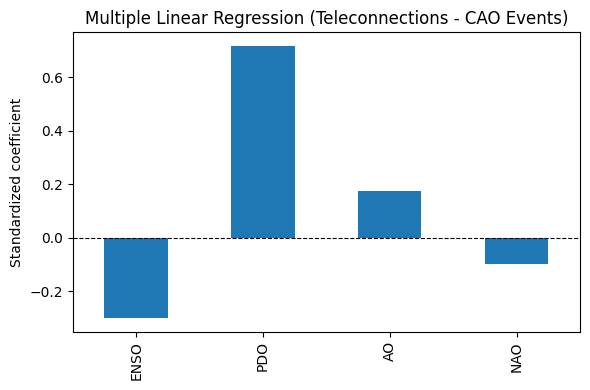

In [ ]:
# Multiple linear regression

# create mlr df
df_mlr = pd.concat(
    [
        cao_events_per_season.rename("n_events"),
        tele_leads_djf[["ENSO", "PDO", "AO", "NAO"]]  
    ],
    axis=1
).dropna()

print(df_mlr.head())

# Predictors
X = df_mlr[["ENSO", "PDO", "AO", "NAO"]]

X_std = (X - X.mean()) / X.std()

# Response
y = df_mlr["n_events"].astype(float)

# Add intercept
X_std = sm.add_constant(X_std)

# Fit model
mlr = sm.OLS(y, X_std).fit()

# Print summary
print(mlr.summary())

coef = mlr.params.drop("const")

# plot coefficients
plt.figure(figsize=(6,4))
coef.plot(kind="bar")
plt.axhline(0, color="k", linestyle="--", linewidth=0.8)
plt.ylabel("Standardized coefficient")
plt.title("Multiple Linear Regression (Teleconnections - CAO Events)")
plt.tight_layout()
plt.savefig("code/figures/mlr_tele_cao.png", dpi=300, bbox_inches="tight")
plt.show()

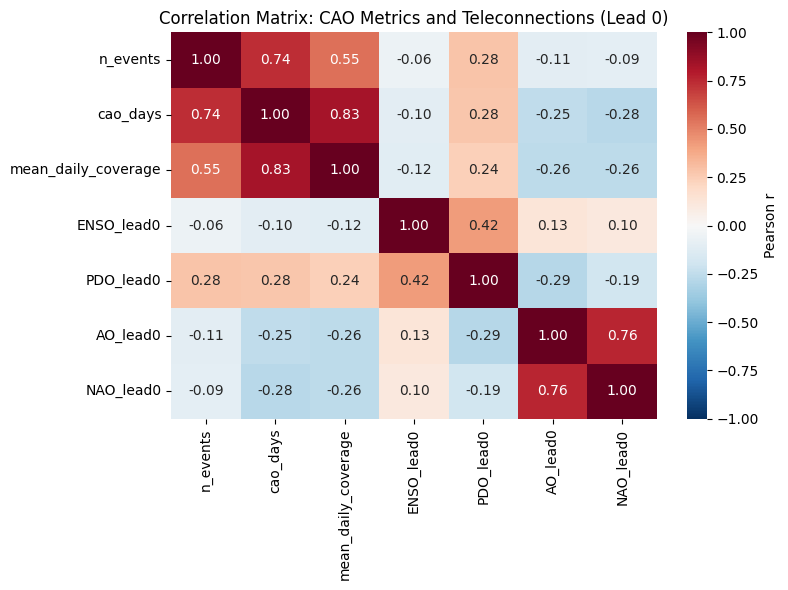

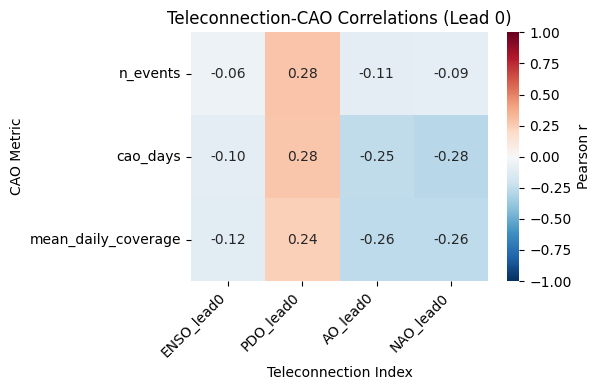

In [ ]:
# Teleconnection-CAO Correlation Matrix (Lead 0)

# Join CAO metrics and teleconnection indices 
df_corr = cao_summary.join(tele_leads_djf, how="inner").dropna()

# select lead0
tele_cols_lead0 = ["ENSO_lead0", "PDO_lead0", "AO_lead0", "NAO_lead0"]

# Columns for CAO metrics
cao_metric_cols = ["n_events", "cao_days", "mean_daily_coverage"]

# Subset 
corr_df = df_corr[cao_metric_cols + tele_cols_lead0]

# Compute correlation matrix
corr_matrix = corr_df.corr()

# Show the full matrix 
plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="RdBu_r",
    vmin=-1,
    vmax=1,
    cbar_kws={"label": "Pearson r"}
)
plt.title("Correlation Matrix: CAO Metrics and Teleconnections (Lead 0)")
plt.tight_layout()
plt.savefig("code/figures/orrelation_matrix.png", dpi=300, bbox_inches = "tight")
plt.show()


# Extract sub-matrix of metrics x teleconnections
sub_corr = corr_matrix.loc[cao_metric_cols, tele_cols_lead0]

plt.figure(figsize=(6, 4))
sns.heatmap(
    sub_corr,
    annot=True,
    fmt=".2f",
    cmap="RdBu_r",
    vmin=-1,
    vmax=1,
    cbar_kws={"label": "Pearson r"}
)
plt.xticks(rotation=45, ha='right')
plt.title("Teleconnection-CAO Correlations (Lead 0)")
plt.xlabel("Teleconnection Index")
plt.ylabel("CAO Metric")
plt.tight_layout()
plt.savefig("code/figures/sub_correlation_matrix.png", dpi=300, bbox_inches = "tight")
plt.show()


#### Distributed lag model

             n_events      ENSO       PDO        AO       NAO  ENSO_lead0  \
season_year                                                                 
1951              4.0 -2.035556 -1.256667 -0.804333 -0.080000   -2.035556   
1952              2.0  0.597778 -1.663333  0.202667  0.473333    0.597778   
1954              2.0 -0.202222 -0.753333  0.082000  0.213333   -0.202222   
1955              3.0 -0.802222 -0.250000 -0.717333 -0.756667   -0.802222   
1956              3.0 -1.268889 -2.246667 -1.225667 -0.390000   -1.268889   

             ENSO_lead1  ENSO_lead2  PDO_lead0  PDO_lead1  PDO_lead2  \
season_year                                                            
1951          -2.257778   -2.218889  -1.256667  -1.233333  -1.476667   
1952           0.708889    0.914444  -1.663333  -1.316667  -0.616667   
1954          -0.191111    0.414444  -0.753333  -0.606667  -0.723333   
1955           0.308889   -0.252222  -0.250000   0.370000   0.453333   
1956          -0.991111   -0

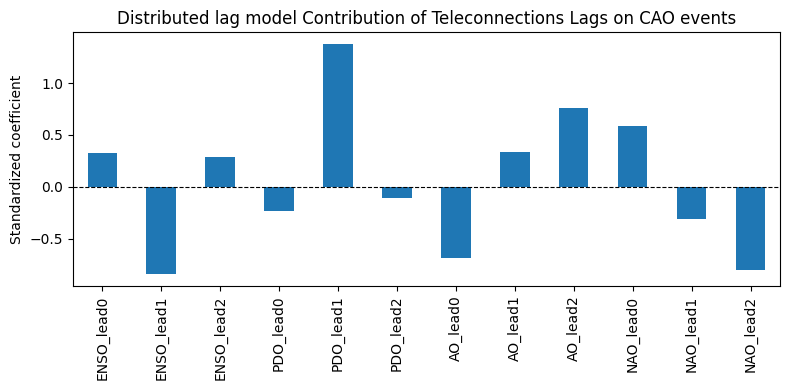

In [ ]:
# create distributed lag model df
df_tele_cao = pd.concat(
    [cao_events_per_season.rename("n_events"), tele_leads_djf],
    axis=1
).dropna()

print(df_tele_cao.head())

# distributed lag predictors
predictor_cols = ["ENSO_lead0", "ENSO_lead1", "ENSO_lead2",
                  "PDO_lead0",  "PDO_lead1",  "PDO_lead2",
                  "AO_lead0", "AO_lead1", "AO_lead2",
                  "NAO_lead0", "NAO_lead1", "NAO_lead2"]

predictor_cols = [c for c in predictor_cols if c in df_tele_cao.columns]

# Set predictor and response
X = df_tele_cao[predictor_cols].copy()
y = df_tele_cao["n_events"].astype(float)

X_std = (X - X.mean()) / X.std()

# Add intercept
X_std = sm.add_constant(X_std)

# Fit distributed lag model (ordinary least squares) 
dlm = sm.OLS(y, X_std).fit()

# print summary
print(dlm.summary())

coef = dlm.params.drop("const")

# print coefficients by predictor
print("\nStandardized coefficients by predictor:")
print(coef)

# Plot coefficients
plt.figure(figsize=(8,4))
coef.plot(kind="bar")
plt.axhline(0, color="k", linestyle="--", linewidth=0.8)
plt.ylabel("Standardized coefficient")
plt.title("Distributed lag model Contribution of Teleconnections Lags on CAO events")
plt.tight_layout()
plt.savefig("code/figures/dlm_contribution_plot.png", dpi=300, bbox_inches = "tight")
plt.show()


#### Time series of cool-phase vs warm-phase CAO counts

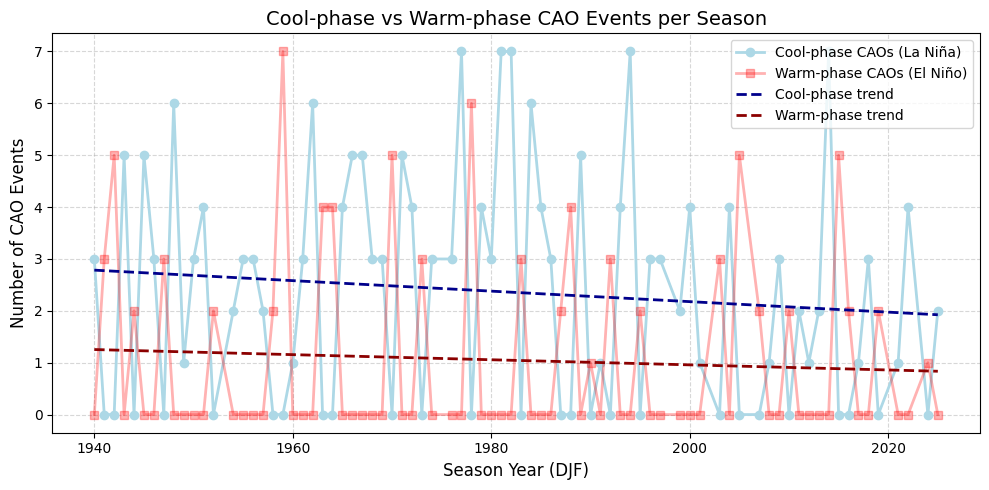

In [ ]:
# create cool/warm phase time series df
events_per_season_s = (
    events_df.groupby('season_year')
             .size()
             .rename('n_events')
)

# select phases
phase = pd.Series(index=tele_leads_djf.index, dtype="object")
phase[tele_leads_djf["ENSO"] > 0] = "warm"
phase[tele_leads_djf["ENSO"] < 0] = "cool"
phase[tele_leads_djf["ENSO"] == 0] = "neutral"   
phase_events = pd.concat([events_per_season_s.rename("n_events"), phase.rename("phase")], axis=1)
phase_events = phase_events.dropna()
phase_events.head()

# separate phases
cool_ts = phase_events[phase_events["phase"] == "cool"]["n_events"]
warm_ts = phase_events[phase_events["phase"] == "warm"]["n_events"]

all_years = events_per_season_s.index
cool_ts = cool_ts.reindex(all_years, fill_value=0)
warm_ts = warm_ts.reindex(all_years, fill_value=0)

years = cool_ts.index.values.astype(float)

# fit linear trend
cool_coef = np.polyfit(years, cool_ts.values, 1)
warm_coef = np.polyfit(years, warm_ts.values, 1)

cool_trend = np.polyval(cool_coef, years)
warm_trend = np.polyval(warm_coef, years)

# plot time series
plt.figure(figsize=(10,5))

plt.plot(years, cool_ts.values,
         marker="o", linewidth=2, color="lightblue",
         label="Cool-phase CAOs (La Niña)")

plt.plot(years, warm_ts.values,
         marker="s", linewidth=2, color="red",alpha=0.3,
         label="Warm-phase CAOs (El Niño)")

# trend lines
plt.plot(years, cool_trend,
         linestyle="--", linewidth=2, color="darkblue",
         label="Cool-phase trend")

plt.plot(years, warm_trend,
         linestyle="--", linewidth=2, color="darkred",
         label="Warm-phase trend")

plt.xlabel("Season Year (DJF)", fontsize=12)
plt.ylabel("Number of CAO Events", fontsize=12)
plt.title("Cool-phase vs Warm-phase CAO Events per Season", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig("code/figures/cool_warm_phase_timeseries.png",dpi=300, bbox_inches="tight")
plt.show()


## Impact-Based Clustering of CAO Events

Cluster CAO events based on:

1. Spatial pattern of t2m anomalies during each event

2. Scalar descriptors (duration, mean intensity, spatial footprint)

In [ ]:
event_maps = []   
event_scalars = [] 

t2m_djf_clim = t2m_djf_daily.mean("time")
t2m_djf_anom = t2m_djf_daily - t2m_djf_clim

for i, row in events_df.iterrows():
    sy = row["season_year"]
    start = row["start"]
    end   = row["end"]

    event_mask = (t2m_djf_daily["time"] >= np.datetime64(start)) & \
                 (t2m_djf_daily["time"] <= np.datetime64(end))

    # Mean anomaly over all event days
    t2m_event_mean = t2m_djf_anom.sel(time=event_mask).mean("time")

    # Store
    event_maps.append(t2m_event_mean)

    # Scalar metrics
    event_scalars.append({
        "season_year": sy,
        "duration": row["duration_days"],
        "coverage": row["regional_coverage_mean"],
        "intensity": row["mean_temp_below_thr"]
    })

# Convert each event map to a 1D array
flat_maps = [m.values.flatten() for m in event_maps]

# Convert to numeric 2D matrix - n_events × n_features
X_maps = np.vstack(flat_maps)

df_scalars = pd.DataFrame(event_scalars)

# Standardize scalars
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scalars = scaler.fit_transform(df_scalars[["duration","coverage","intensity"]])

#combine 
X = np.hstack([X_maps, X_scalars])

# Dimensionality reduction (PCA)
pca = PCA(n_components=10)  
X_pca = pca.fit_transform(X)

# print explained variance
print("Explained variance:", pca.explained_variance_ratio_.cumsum())


Explained variance: [0.49691793 0.72559428 0.81914323 0.87247381 0.89726404 0.91574798
 0.92770288 0.93839136 0.94537877 0.95183994]


Best k: 2 score: 0.3604643094590512


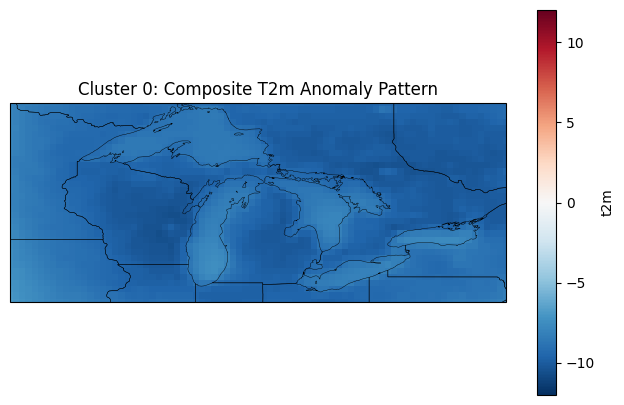

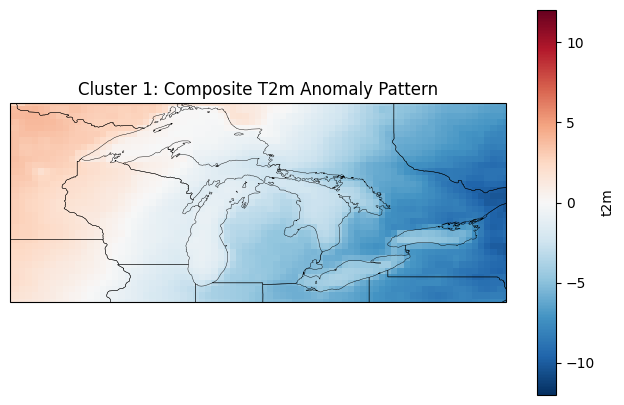

In [ ]:
# K means clustering
best_k = None
best_score = -1
scores = {}

# loop through k # of cluster to find best # using silhouette score
for k in range(2,7):
    km = KMeans(n_clusters=k, random_state=42, n_init=20)
    labels = km.fit_predict(X_pca)
    score = silhouette_score(X_pca, labels)
    scores[k] = score
    if score > best_score:
        best_score = score
        best_k = k

#print best K
print("Best k:", best_k, "score:", best_score)

# cluster
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=20)
labels = kmeans.fit_predict(X_pca)

events_df["cluster"] = labels
df_scalars["cluster"] = labels

# Plot cluster composite maps
clusters = sorted(events_df["cluster"].unique())

for cl in clusters:
    group_maps = [event_maps[i] for i in range(len(event_maps))
                  if events_df["cluster"].iloc[i] == cl]

    composite = xr.concat(group_maps, dim="event").mean("event")

    # Plot
    fig = plt.figure(figsize=(8,5))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([-95,-75,41,49])
    composite.plot(
        ax=ax, cmap="RdBu_r", vmin=-12, vmax=12,
        transform=ccrs.PlateCarree(),
        add_colorbar=True
    )
    ax.coastlines()
    ax.add_feature(cfeature.STATES,linewidth=0.3)
    ax.set_title(f"Cluster {cl}: Composite T2m Anomaly Pattern")
    plt.savefig(f"code/figures/impact_cluster_{cl}_composites.png", dpi=300, bbox_inches="tight")    
    plt.show()


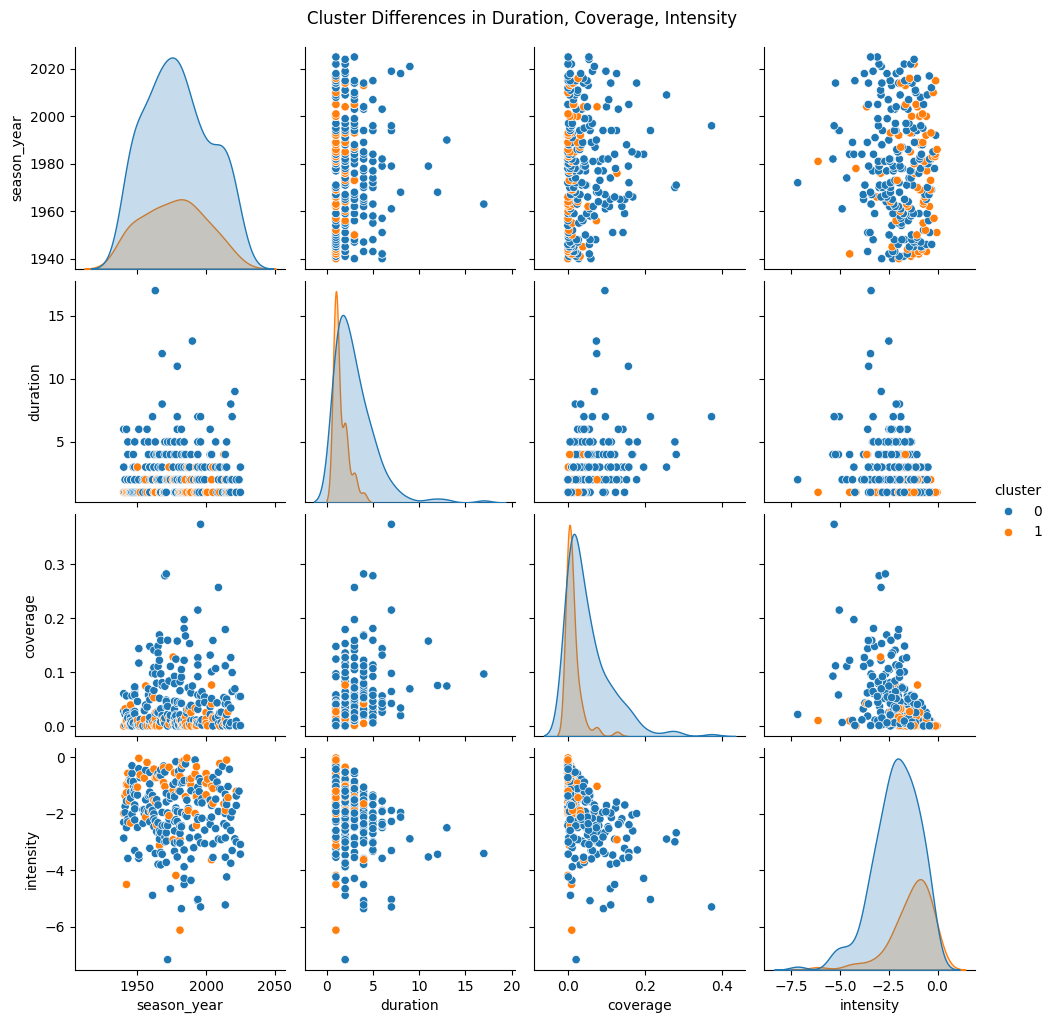

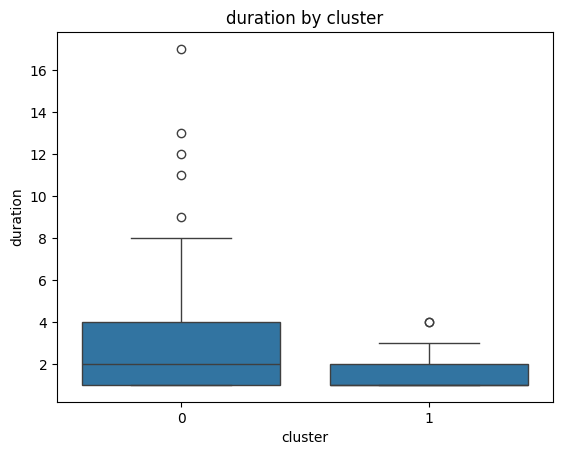

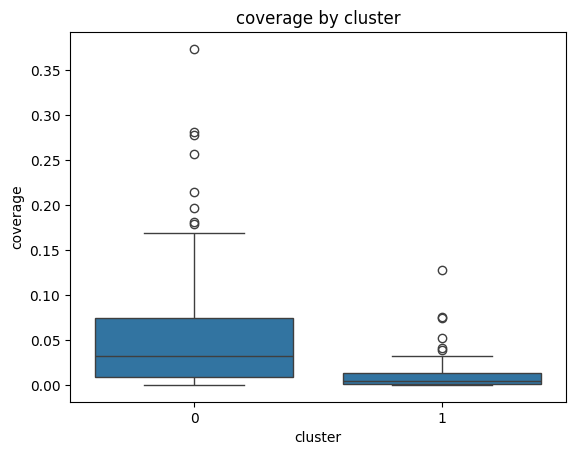

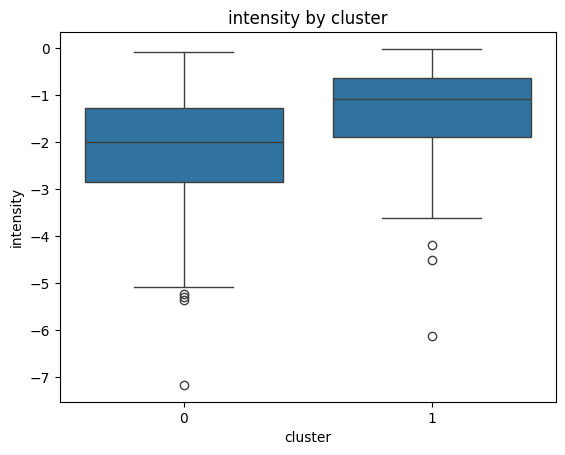

In [53]:
# Plot scalar metrics by cluster
sns.pairplot(df_scalars, hue="cluster", diag_kind="kde")
plt.suptitle("Cluster Differences in Duration, Coverage, Intensity", y=1.02)
plt.savefig("/Users/Haley/Desktop/Capstone-2/great_lakes_capstone_2/code/figures/cluster_pairplot.png", dpi=300, bbox_inches="tight")
plt.show()

for var in ["duration","coverage","intensity"]:
    sns.boxplot(x="cluster", y=var, data=df_scalars)
    plt.title(f"{var} by cluster")
    plt.show()



## Teleconnection-Based Clustering of CAO Events

Using teleconnection features: ['ENSO', 'PDO', 'AO', 'NAO', 'ENSO_lead1', 'PDO_lead1', 'AO_lead1', 'NAO_lead1', 'ENSO_lead2', 'PDO_lead2', 'AO_lead2', 'NAO_lead2']
Silhouette scores by k: {2: 0.2685209992259504, 3: 0.2789654000070851, 4: 0.26446291413876266, 5: 0.25699437922543084}
Chosen k for teleconnection clustering: 3
   season_year  tele_cluster
0         1940          <NA>
1         1940          <NA>
2         1940          <NA>
3         1941          <NA>
4         1941          <NA>


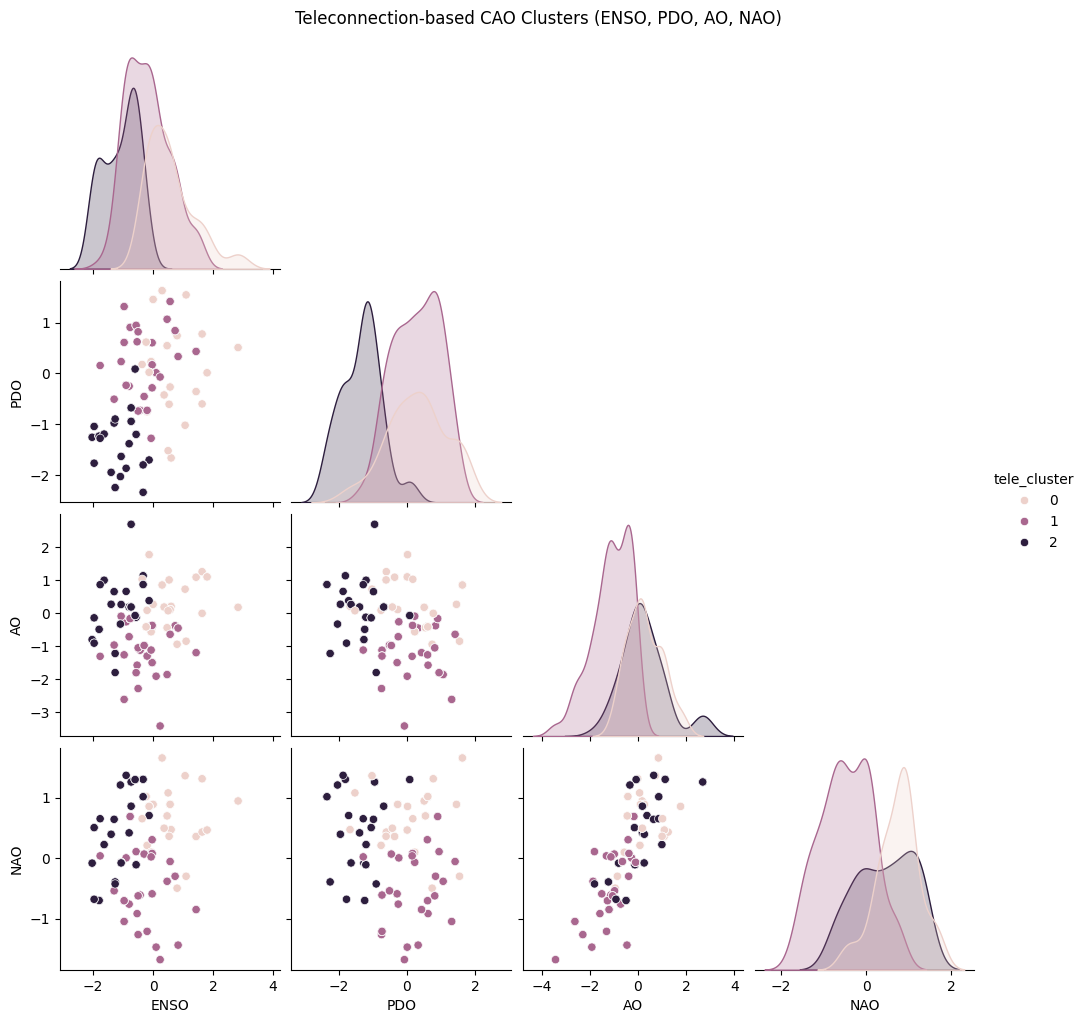

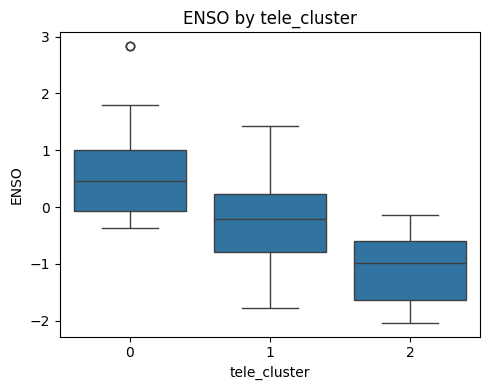

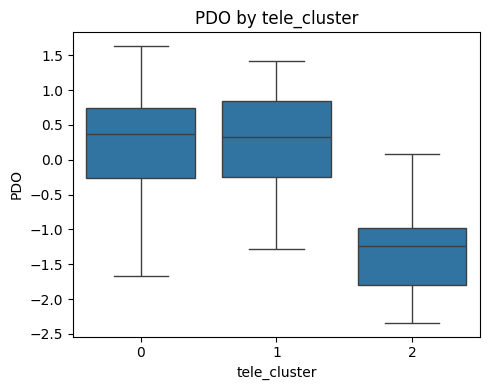

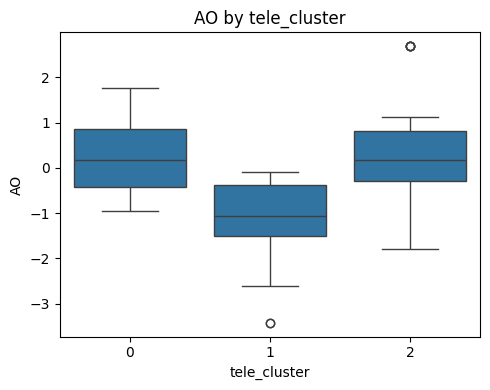

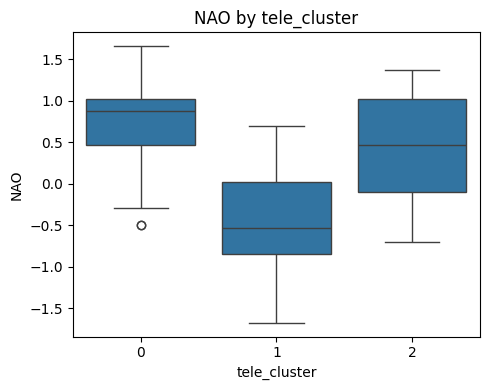

In [ ]:
# copy tele df
events_df["season_year"] = events_df["season_year"].astype(int)
tele_tmp = tele_leads_djf.copy()
tele_tmp.index = tele_tmp.index.astype(int)

# merge event_tele with tele_tmp
event_tele = events_df.merge(
    tele_tmp,
    left_on="season_year",
    right_index=True,
    how="left"
)

# teleconnection features with lags
tele_features = [
    "ENSO", "PDO", "AO", "NAO",        
    "ENSO_lead1", "PDO_lead1", "AO_lead1", "NAO_lead1",
    "ENSO_lead2", "PDO_lead2", "AO_lead2", "NAO_lead2"
]

tele_features = [f for f in tele_features if f in event_tele.columns]
print("Using teleconnection features:", tele_features)

# drop nan
X = event_tele[tele_features].dropna()
valid_idx = X.index  

# Standardize features
scaler_tele = StandardScaler()
X_std = scaler_tele.fit_transform(X)

# choose number of clusters with silhouette score
best_k = None
best_score = -1
scores = {}

# loop through k 2-6
for k in range(2, 6):   
    km = KMeans(n_clusters=k, random_state=42, n_init=20)
    labels = km.fit_predict(X_std)
    score = silhouette_score(X_std, labels)
    scores[k] = score
    if score > best_score:
        best_score = score
        best_k = k

# print chosen # of K
print("Silhouette scores by k:", scores)
print("Chosen k for teleconnection clustering:", best_k)

# Final clustering with chosen k
kmeans_tele = KMeans(n_clusters=best_k, random_state=42, n_init=20)
tele_labels = kmeans_tele.fit_predict(X_std)

events_df["tele_cluster"] = np.nan
events_df.loc[valid_idx, "tele_cluster"] = tele_labels
events_df["tele_cluster"] = events_df["tele_cluster"].astype("Int64")

print(events_df[["season_year", "tele_cluster"]].head())

# plot
# Subset to rows 
df_tele_clusters = event_tele.loc[valid_idx, tele_features].copy()
df_tele_clusters["tele_cluster"] = tele_labels

# Pairplot of ENSO/PDO features colored by tele_cluster
sns.pairplot(df_tele_clusters, vars=["ENSO", "PDO", "AO", "NAO"], hue="tele_cluster",
             diag_kind="kde", corner=True)
plt.suptitle("Teleconnection-based CAO Clusters (ENSO, PDO, AO, NAO)", y=1.02)
plt.savefig("code/figures/pairplot_tele.png", dpi=300,bbox_inches="tight")
plt.show()

# Boxplots to see how clusters differ in ENSO/PDO
for var in ["ENSO", "PDO", "AO", "NAO"]:
    plt.figure(figsize=(5,4))
    sns.boxplot(x="tele_cluster", y=var, data=df_tele_clusters)
    plt.title(f"{var} by tele_cluster")
    plt.tight_layout()
    plt.show()


In [ ]:
# print mean duration and intensity by cluster
for k in [0,1]:
    comp = events_df.loc[events_df.tele_cluster == k]
    print(f"Mean duration for cluster {k}: {comp['duration_days'].mean():.2f}")
    print(f"Mean intensity for cluster {k}: {comp['mean_temp_below_thr'].mean():.2f}")


Mean duration for cluster 0: 2.55
Mean intensity for cluster 0: -1.79
Mean duration for cluster 1: 2.99
Mean intensity for cluster 1: -1.99


## Spatial Subdomains CAO Metrics & Trends

#### Define Regional Masks

In [55]:
# Regional masks
lat = cold_events.latitude
lon = cold_events.longitude

# Rough midpoints of domain 
lat_mid = 45.0
lon_mid = -85.0

# Boolean masks 
north_mask   = lat >= lat_mid
south_mask   = lat <  lat_mid
upwind_mask  = lon <= lon_mid     
downwind_mask = lon > lon_mid   

north_mask_3d    = cold_events * 0 + north_mask
south_mask_3d    = cold_events * 0 + south_mask
upwind_mask_3d   = cold_events * 0 + upwind_mask
downwind_mask_3d = cold_events * 0 + downwind_mask

# Area weights
lat_weights = np.cos(np.deg2rad(lat))


In [ ]:
# Compute CAO days and CAO events per region 

def regional_daily_cao_boolean(cold_events, region_mask_3d):
    ce_region = cold_events.where(region_mask_3d)
    daily_any = ce_region.any(dim=("latitude", "longitude"))
    return daily_any

# Daily boolean per region
north_daily  = regional_daily_cao_boolean(cold_events, north_mask_3d)
south_daily  = regional_daily_cao_boolean(cold_events, south_mask_3d)
upwind_daily = regional_daily_cao_boolean(cold_events, upwind_mask_3d)
down_daily   = regional_daily_cao_boolean(cold_events, downwind_mask_3d)

# CAO days per season_year
north_cao_days    = north_daily.groupby(season_year).sum().to_pandas()
south_cao_days    = south_daily.groupby(season_year).sum().to_pandas()
upwind_cao_days   = upwind_daily.groupby(season_year).sum().to_pandas()
downwind_cao_days = down_daily.groupby(season_year).sum().to_pandas()

# CAO events per region 
def count_events(daily_boolean, sy):
    df = pd.DataFrame({
        "cao": daily_boolean.values,
        "sy":  sy.values,
    })
    out = {}
    for year, grp in df.groupby("sy"):
        runs = ((grp["cao"] != grp["cao"].shift()).cumsum())
        events = grp.groupby(runs)["cao"].apply(lambda x: x.all())
        out[year] = int(events.sum())
    return pd.Series(out)

north_n_events    = count_events(north_daily.to_pandas(), season_year.to_pandas())
south_n_events    = count_events(south_daily.to_pandas(), season_year.to_pandas())
upwind_n_events   = count_events(upwind_daily.to_pandas(), season_year.to_pandas())
downwind_n_events = count_events(down_daily.to_pandas(), season_year.to_pandas())

# create combined regional metrics df
regional_metrics_df = pd.DataFrame({
    "north_cao_days":     north_cao_days,
    "south_cao_days":     south_cao_days,
    "upwind_cao_days":    upwind_cao_days,
    "downwind_cao_days":  downwind_cao_days,

    "north_n_events":     north_n_events,
    "south_n_events":     south_n_events,
    "upwind_n_events":    upwind_n_events,
    "downwind_n_events":  downwind_n_events,
})

regional_metrics_df.index.name = "season_year"

print("regional_metrics_df (head):")
print(regional_metrics_df.head())


regional_metrics_df (head):
             north_cao_days  south_cao_days  upwind_cao_days  \
season_year                                                    
1940                     60              60               60   
1941                     90              90               90   
1942                     90              90               90   
1943                     90              90               90   
1944                     91              91               91   

             downwind_cao_days  north_n_events  south_n_events  \
season_year                                                      
1940                        60               1               1   
1941                        90               1               1   
1942                        90               1               1   
1943                        90               1               1   
1944                        91               1               1   

             upwind_n_events  downwind_n_events  
season_yea

In [ ]:
# inland/lakefront mask


# path
shp_root = "/Users/Haley/Desktop/Capstone-2/great_lakes_capstone_2/data/GL251212_lam"
shp_path = "/Users/Haley/Desktop/Capstone-2/great_lakes_capstone_2/data/GL251212_lam/GL251212_lam.shp"


# Read shapefile
gdf = gpd.read_file(shp_path)
print("CRS:", gdf.crs)
print("Columns:", list(gdf.columns))
print("Geometry types:", gdf.geom_type.unique())

gdf = gdf[gdf.geometry.notnull()].copy()
gdf = gdf[gdf.geom_type.isin(["Polygon", "MultiPolygon"])].copy()

# reproject to lat/lon
if gdf.crs is None:
    raise ValueError("Shapefile has no CRS. Check .prj file is present in the folder.")
if gdf.crs.to_epsg() != 4326:
    gdf = gdf.to_crs(epsg=4326)

# Dissolve into one
lakes_geom = unary_union(gdf.geometry)

# Build mask on ERA5 grid
grid = cold_events 

lats = grid.latitude.values
lons = grid.longitude.values
lon2d, lat2d = np.meshgrid(lons, lats)

lake_mask_2d = contains(lakes_geom, lon2d, lat2d)

lakefront_mask = xr.DataArray(
    lake_mask_2d,
    coords={"latitude": grid.latitude, "longitude": grid.longitude},
    dims=("latitude", "longitude"),
    name="lake_mask"
)

# select inland mask
inland_mask = (~lakefront_mask).rename("inland_mask")

lakefront_mask, inland_mask


CRS: PROJCS["WGS_1984_Lambert_Conformal_Conic",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["latitude_of_origin",40],PARAMETER["central_meridian",-100],PARAMETER["standard_parallel_1",49],PARAMETER["standard_parallel_2",77],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Columns: ['ICECODE', 'CT', 'CA', 'CB', 'CC', 'SA', 'SB', 'SC', 'SO', 'SD', 'FA', 'FB', 'FC', 'FP', 'FS', 'POLY_TYPE', 'Shape_Leng', 'Shape_Area', 'geometry']
Geometry types: ['Polygon']


/var/folders/yn/jk_z3jjj5bq9hv1j210z7_800000gn/T/ipykernel_63975/3014926216.py:46: DeprecationWarning: The 'shapely.vectorized.contains' function is deprecated and will be removed a future version. Use 'shapely.contains_xy' instead (available since shapely 2.0.0).
  lake_mask_2d = contains(lakes_geom, lon2d, lat2d)


(<xarray.DataArray 'lake_mask' (latitude: 33, longitude: 81)> Size: 3kB
 array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]], shape=(33, 81))
 Coordinates:
   * latitude   (latitude) float64 264B 49.0 48.75 48.5 48.25 ... 41.5 41.25 41.0
   * longitude  (longitude) float64 648B -95.0 -94.75 -94.5 ... -75.25 -75.0,
 <xarray.DataArray 'inland_mask' (latitude: 33, longitude: 81)> Size: 3kB
 array([[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ 

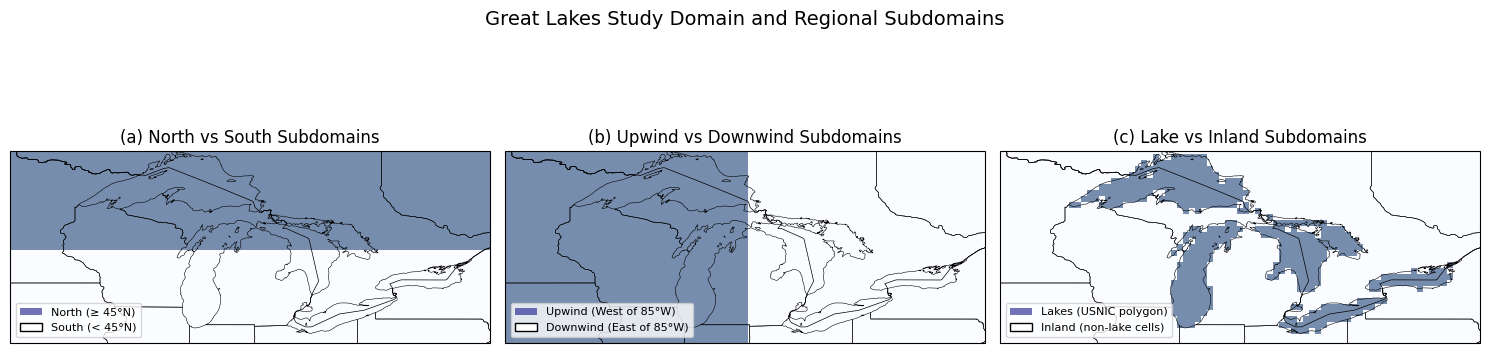

In [ ]:
# Plot map of domain with defined subregions
#  North vs South
#  Upwind vs Downwind
#  Lakefront vs Inland

# force any mask into 2D boolean numpy array

def to_mask2d(mask):
    if hasattr(mask, "values"):   
        arr = mask.values
    else:
        arr = mask
    arr = np.asarray(arr)
    if arr.ndim != 2:
        raise ValueError(f"Mask must be 2D (lat, lon). Got shape {arr.shape}")
    return arr.astype(bool)

# Build lon/lat mesh 
da = cold_events  
lat = da.latitude.values
lon = da.longitude.values
lon2d, lat2d = np.meshgrid(lon, lat)

# Domain bounds
lat_min, lat_max = 41.0, 49.0
lon_min, lon_max = -95.0, -75.0

# North/South & Upwind/Downwind masks
lat_mid = 45.0
lon_mid = -85.0

north_mask_2d    = (lat2d >= lat_mid)
south_mask_2d    = (lat2d <  lat_mid)
upwind_mask_2d   = (lon2d <= lon_mid)
downwind_mask_2d = (lon2d >  lon_mid)

# Two-class plot function 
def plot_two_region_mask(ax, mask_a, mask_b, label_a, label_b, title):
    mask_a = to_mask2d(mask_a)
    mask_b = to_mask2d(mask_b)

    #  must partition domain
    if not np.all(mask_a | mask_b):
        print(f"Warning: {title} masks do not cover full domain")
    if np.any(mask_a & mask_b):
        print(f"Warning: {title} masks overla")

    field = np.zeros_like(mask_a, dtype=int)
    field[mask_a] = 1

    # colors
    cmap="Blues"

    ax.pcolormesh(
        lon2d, lat2d, field,
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        shading="auto",
        alpha=0.55
    )

    ax.coastlines(resolution="10m", linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.add_feature(cfeature.STATES, linewidth=0.4)
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    ax.set_title(title)

    legend_handles = [
        Patch(facecolor="navy",  alpha=0.55, label=label_a),
        Patch(facecolor="white", alpha=1.00, edgecolor="k", label=label_b),
    ]
    ax.legend(handles=legend_handles, loc="lower left", fontsize=8)


# Plot 3 panels
proj = ccrs.PlateCarree()
fig, axes = plt.subplots(1, 3, figsize=(15, 4), subplot_kw={"projection": proj})

# plot north south
plot_two_region_mask(
    axes[0],
    north_mask_2d,
    south_mask_2d,
    label_a="North (≥ 45°N)",
    label_b="South (< 45°N)",
    title="(a) North vs South Subdomains"
)

# plot upwind downwind
plot_two_region_mask(
    axes[1],
    upwind_mask_2d,
    downwind_mask_2d,
    label_a="Upwind (West of 85°W)",
    label_b="Downwind (East of 85°W)",
    title="(b) Upwind vs Downwind Subdomains"
)

# plot lakefront inland
plot_two_region_mask(
    axes[2],
    lakefront_mask,  
    inland_mask,      
    label_a="Lakes (USNIC polygon)",
    label_b="Inland (non-lake cells)",
    title="(c) Lake vs Inland Subdomains"
)

plt.suptitle("Great Lakes Study Domain and Regional Subdomains", fontsize=14, y=1.05)
plt.tight_layout()

plt.savefig("code/figures/subregion_domain_map.png",dpi=300, bbox_inches="tight")
plt.show()


#### Trends

In [ ]:
def regional_cao_fraction(cold_events, region_mask_3d, lat_weights, season_year):
    # weights only inside region 
    w_region = (lat_weights.where(region_mask_3d.isel(time=0), 0.0)
                               .broadcast_like(cold_events))

    # daily area-fraction of the region in CAO
    frac_daily = (
        cold_events.where(region_mask_3d)
                   .weighted(w_region)
                   .mean(dim=("latitude", "longitude"))
    ) 

    # fraction of DJF days that are CAO per season_year
    frac_season = (
        frac_daily.groupby(season_year)
                  .mean("time")
                  .to_pandas()
                  .rename("cao_frac")
    )
    return frac_season

# fraction of cao days
cao_frac_north    = regional_cao_fraction(cold_events, north_mask_3d,    lat_weights, season_year)
cao_frac_south    = regional_cao_fraction(cold_events, south_mask_3d,    lat_weights, season_year)
cao_frac_upwind   = regional_cao_fraction(cold_events, upwind_mask_3d,   lat_weights, season_year)
cao_frac_downwind = regional_cao_fraction(cold_events, downwind_mask_3d, lat_weights, season_year)

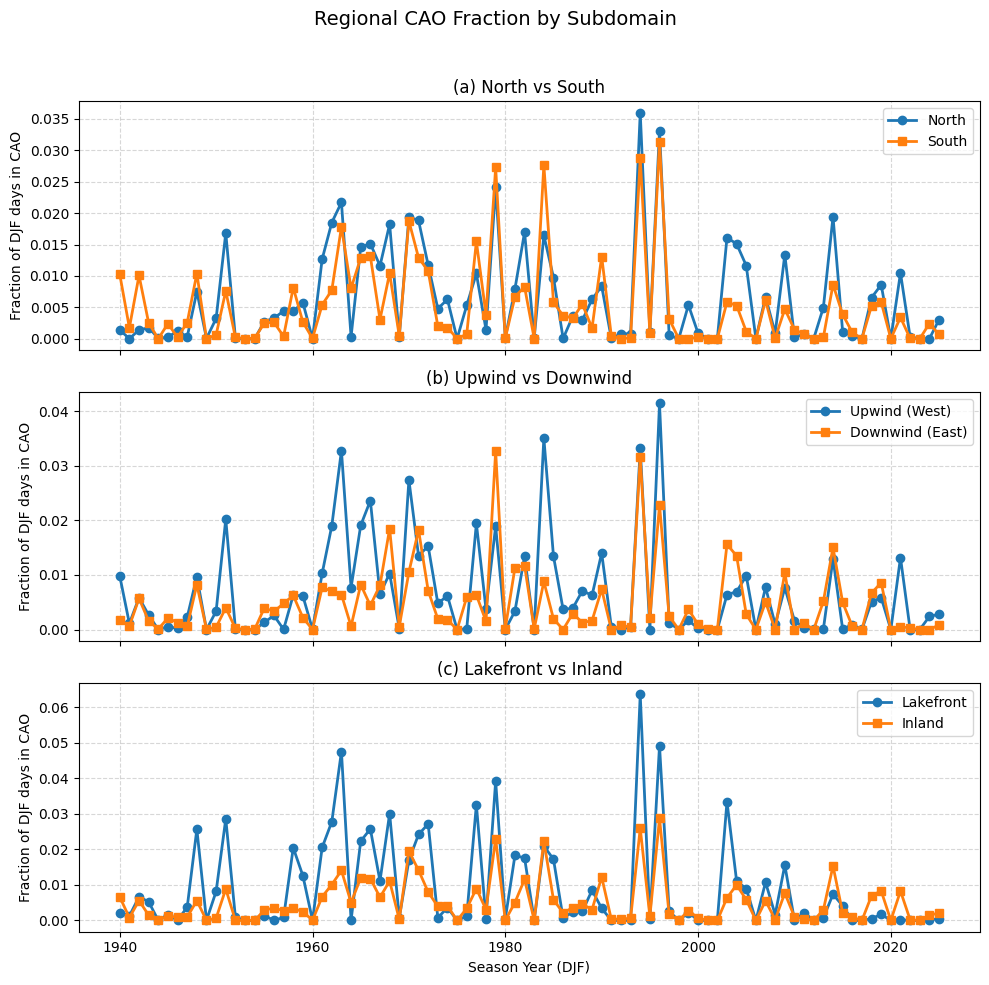

In [ ]:
# lat/lon 
lat = cold_events.latitude
lon = cold_events.longitude
lon2d, lat2d = np.meshgrid(lon, lat)

lat_mid = 45.0
lon_mid = -85.0


def mask2da(mask_2d, name):
    return xr.DataArray(
        mask_2d,
        coords={"latitude": lat, "longitude": lon},
        dims=("latitude", "longitude"),
        name=name
    )

# masks
north_mask = mask2da(north_mask_2d, "north_mask")
south_mask = mask2da(south_mask_2d, "south_mask")
upwind_mask = mask2da(upwind_mask_2d, "upwind_mask")
downwind_mask = mask2da(downwind_mask_2d, "downwind_mask")
lakefront_mask = mask2da(lakefront_mask, "lakefront_mask")
inland_mask = mask2da(inland_mask, "inland_mask")

# latitude weights 
lat_weights = np.cos(np.deg2rad(lat))
lat_weights = xr.DataArray(lat_weights, coords={"latitude": lat}, dims=("latitude",))

# season_year coordinate aligned with cold_events
season_year = cold_events["time"].dt.year + (cold_events["time"].dt.month == 12).astype(int)
season_year = xr.DataArray(season_year.values, coords={"time": cold_events.time}, dims=("time",), name="season_year")

def regional_cao_fraction(cold_events, region_mask_2d, lat_weights, season_year):
    region_mask_3d = region_mask_2d.broadcast_like(cold_events)

    # weights only inside region 
    w2d = lat_weights.broadcast_like(cold_events.isel(time=0))
    w2d_region = w2d.where(region_mask_2d, 0.0)
    w_region = w2d_region.broadcast_like(cold_events)

    frac_daily = (
        cold_events.where(region_mask_3d)
                   .weighted(w_region)
                   .mean(dim=("latitude", "longitude"))
    )

    frac_season = (
        frac_daily.groupby(season_year)
                  .mean("time")
                  .to_pandas()
                  .rename("cao_frac")
    )
    return frac_season

# Lakefront vs Inland CAO fraction
cao_frac_lake = regional_cao_fraction(
    cold_events,
    lakefront_mask,
    lat_weights,
    season_year
)

cao_frac_inland = regional_cao_fraction(
    cold_events,
    inland_mask,
    lat_weights,
    season_year
)


# Plot regional fraction of cao days timeseries
fig, axes = plt.subplots(nrows=3, ncols=1,figsize=(10, 10),sharex=True)

# North vs South
axes[0].plot(
    cao_frac_north.index, cao_frac_north.values,
    marker="o", linewidth=2, label="North"
)
axes[0].plot(
    cao_frac_south.index, cao_frac_south.values,
    marker="s", linewidth=2, label="South"
)
axes[0].set_ylabel("Fraction of DJF days in CAO")
axes[0].set_title("(a) North vs South")
axes[0].grid(True, linestyle="--", alpha=0.5)
axes[0].legend()

# Upwind vs Downwind
axes[1].plot(
    cao_frac_upwind.index, cao_frac_upwind.values,
    marker="o", linewidth=2, label="Upwind (West)"
)
axes[1].plot(
    cao_frac_downwind.index, cao_frac_downwind.values,
    marker="s", linewidth=2, label="Downwind (East)"
)
axes[1].set_ylabel("Fraction of DJF days in CAO")
axes[1].set_title("(b) Upwind vs Downwind")
axes[1].grid(True, linestyle="--", alpha=0.5)
axes[1].legend()

# Lakefront vs Inland
axes[2].plot(
    cao_frac_lake.index, cao_frac_lake.values,
    marker="o", linewidth=2, label="Lakefront"
)
axes[2].plot(
    cao_frac_inland.index, cao_frac_inland.values,
    marker="s", linewidth=2, label="Inland"
)
axes[2].set_xlabel("Season Year (DJF)")
axes[2].set_ylabel("Fraction of DJF days in CAO")
axes[2].set_title("(c) Lakefront vs Inland")
axes[2].grid(True, linestyle="--", alpha=0.5)
axes[2].legend()


plt.suptitle("Regional CAO Fraction by Subdomain",fontsize=14,y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("code/figures/regional_cao_fraction_subregions.png",dpi=300,bbox_inches="tight")
plt.show()




In [ ]:
# Add lake/inland to your region dictionary 
regions = {
    "north":    cao_frac_north,
    "south":    cao_frac_south,
    "upwind":   cao_frac_upwind,
    "downwind": cao_frac_downwind,
    "lake":     cao_frac_lake,
    "inland":   cao_frac_inland,
}

trend_results = {}

for name, series in regions.items():
    # drop NaNs 
    series = series.dropna()
    # Mann–Kendall & Sen slope
    mk = mann_kendall_sen_slope(series)
    # OLS linear trend
    years = series.index.values.astype(float)
    slope, intercept = np.polyfit(years, series.values, 1)

    trend_results[name] = {
        "MK_tau": mk["tau"],
        "MK_p": mk["p_value"],
        "Sen_slope_per_year": mk["sen_slope"],
        "Sen_slope_per_decade": mk["sen_slope"] * 10,
        "OLS_slope_per_year": slope,
        "OLS_slope_per_decade": slope * 10,
    }

trend_results

{'north': {'MK_tau': np.float64(-0.036662106703146374),
  'MK_p': np.float64(0.6172163340934369),
  'Sen_slope_per_year': np.float64(-1.1760399016450527e-06),
  'Sen_slope_per_decade': np.float64(-1.1760399016450527e-05),
  'OLS_slope_per_year': np.float64(-1.95386961568352e-07),
  'OLS_slope_per_decade': np.float64(-1.95386961568352e-06)},
 'south': {'MK_tau': np.float64(-0.11080711354309165),
  'MK_p': np.float64(0.13089352085210604),
  'Sen_slope_per_year': np.float64(-1.2281677452421792e-05),
  'Sen_slope_per_decade': np.float64(-0.0001228167745242179),
  'OLS_slope_per_year': np.float64(-3.1459007445989136e-05),
  'OLS_slope_per_decade': np.float64(-0.0003145900744598914)},
 'upwind': {'MK_tau': np.float64(-0.08891928864569083),
  'MK_p': np.float64(0.22543581847191985),
  'Sen_slope_per_year': np.float64(-5.5507222383482835e-06),
  'Sen_slope_per_decade': np.float64(-5.550722238348283e-05),
  'OLS_slope_per_year': np.float64(-3.565967383242193e-05),
  'OLS_slope_per_decade': np.f

## Gridcell CAO Event Frequency & Trend Maps

In [ ]:
# Gridcell CAO Day Frequency & Trend Maps

# total CAO days per gridcell over the full period
cao_days_total = cold_events.sum(dim="time")  # (latitude, longitude)
cao_days_total.name = "cao_days_total"

# Number of DJF seasons
n_seasons = len(np.unique(season_year.values))

# Mean CAO days per DJF season 
cao_days_clim = cao_days_total / n_seasons
cao_days_clim.name = "cao_days_per_season"

#print total cao days and mean cao days 
print("Total CAO days:")
print(cao_days_total.isel(latitude=slice(0,3), longitude=slice(0,3)))

print("Mean CAO days per DJF season:")
print(cao_days_clim.isel(latitude=slice(0,3), longitude=slice(0,3)))


Total CAO days (sample):
<xarray.DataArray 'cao_days_total' (latitude: 3, longitude: 3)> Size: 72B
array([[71, 79, 77],
       [50, 54, 55],
       [47, 47, 47]])
Coordinates:
    number     int64 8B 0
    step       timedelta64[ns] 8B 00:00:00
    surface    float64 8B 0.0
  * latitude   (latitude) float64 24B 49.0 48.75 48.5
  * longitude  (longitude) float64 24B -95.0 -94.75 -94.5
    quantile   float64 8B 0.05

Mean CAO days per DJF season (sample):
<xarray.DataArray 'cao_days_per_season' (latitude: 3, longitude: 3)> Size: 72B
array([[0.8255814 , 0.91860465, 0.89534884],
       [0.58139535, 0.62790698, 0.63953488],
       [0.54651163, 0.54651163, 0.54651163]])
Coordinates:
    number     int64 8B 0
    step       timedelta64[ns] 8B 00:00:00
    surface    float64 8B 0.0
  * latitude   (latitude) float64 24B 49.0 48.75 48.5
  * longitude  (longitude) float64 24B -95.0 -94.75 -94.5
    quantile   float64 8B 0.05


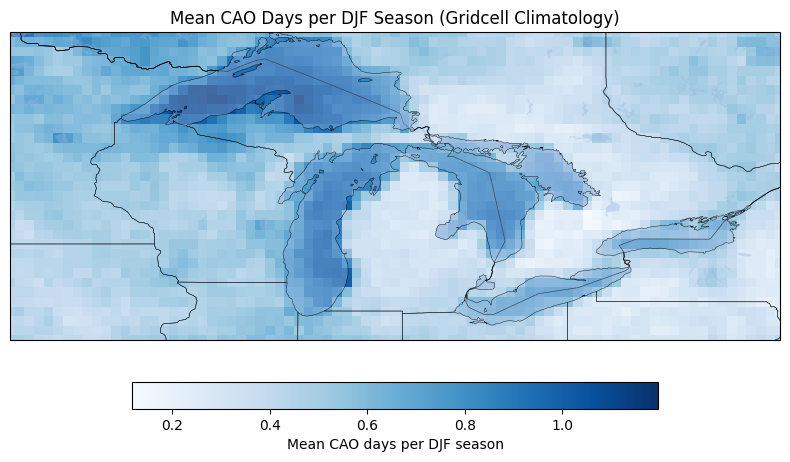

In [ ]:
# Plot Mean CAO days per DJF season
proj = ccrs.PlateCarree()

fig, ax = plt.subplots(figsize=(8,6), subplot_kw={"projection": proj})
pcm = cao_days_clim.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap="Blues",
    cbar_kwargs={"label": "Mean CAO days per DJF season",        
        "orientation": "horizontal",
        "pad": 0.08,        
        "fraction": 0.05},
)
ax.coastlines(resolution="10m", linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAKES, alpha=0.4)
ax.add_feature(cfeature.STATES, linewidth=0.3)

ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
ax.set_title("Mean CAO Days per DJF Season (Gridcell Climatology)")
plt.tight_layout()
plt.savefig("code/figures/mean_cao_per_season.png", dpi=300, bbox_inches="tight")
plt.show()

In [67]:
# CAO days per season_year at each gridcell

cold_int = cold_events.astype(int)

# Group by season_year and sum over days
cao_days_seasonal = cold_int.groupby(season_year).sum(dim="time")
cao_days_seasonal.name = "cao_days_per_season"

print("\nCAO days per season_year (shape):", cao_days_seasonal.shape)

example = cao_days_seasonal.isel(latitude=0, longitude=0).to_pandas()
print("\nExample gridcell CAO days per season:")
print(example.head())


CAO days per season_year (shape): (86, 33, 81)

Example gridcell CAO days per season:
season_year
1940    0
1941    0
1942    1
1943    2
1944    0
Name: cao_days_per_season, dtype: int64


In [ ]:
# Linear trend (OLS) per gridcell 

years = cao_days_seasonal["season_year"].values.astype(float)

# return slope (days per year) for one gridcell time series
def _grid_trend(y, x):
    y = np.asarray(y)
    x = np.asarray(x)
    mask = np.isfinite(y)
    if mask.sum() < 2:
        return np.nan
    # slope in days per year
    p = np.polyfit(x[mask], y[mask], 1)
    return p[0]

trend_slope_per_year = xr.apply_ufunc(
    _grid_trend,
    cao_days_seasonal,
    years,
    input_core_dims=[["season_year"], ["season_year"]],
    output_core_dims=[[]],
    vectorize=True,
    dask="allowed",
    output_dtypes=[float],
)

trend_slope_per_year.name = "cao_trend_days_per_year"

# Convert to days per decade
trend_days_per_decade = trend_slope_per_year * 10.0
trend_days_per_decade.name = "cao_trend_days_per_decade"

print("\nTrend map summary (days/decade):")
print(trend_days_per_decade.quantile([0.1, 0.5, 0.9]).values)



Trend map summary (days/decade):
[-0.07451295 -0.00981178  0.04670032]


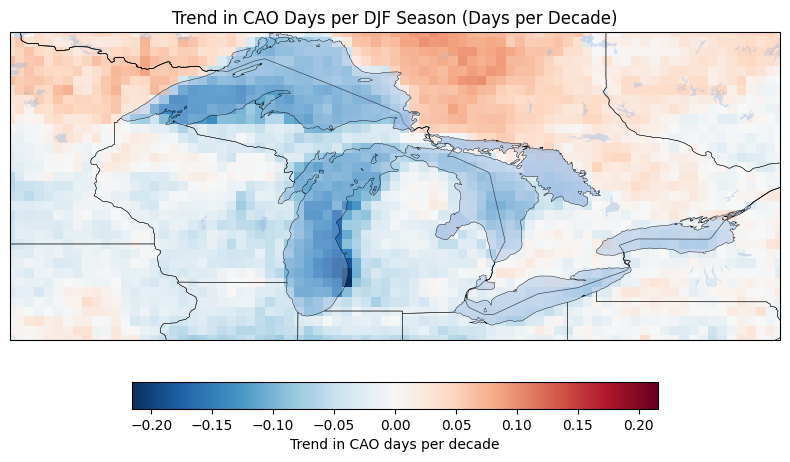

In [ ]:
# Trend map 

fig, ax = plt.subplots(figsize=(8,6), subplot_kw={"projection": proj})

v = np.nanmax(np.abs(trend_days_per_decade.values))
if not np.isfinite(v) or v == 0:
    v = 1.0  

pcm = trend_days_per_decade.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap="RdBu_r",
    vmin=-v,
    vmax=v,
    cbar_kwargs={"label": "Trend in CAO days per decade",        
        "orientation": "horizontal",
        "pad": 0.08,        
        "fraction": 0.05},
)

ax.coastlines(resolution="10m", linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAKES, alpha=0.4)
ax.add_feature(cfeature.STATES, linewidth=0.3)
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
ax.set_title("Trend in CAO Days per DJF Season (Days per Decade)")
plt.tight_layout()
plt.savefig("code/figures/trend_cao_per_season.png", dpi=300, bbox_inches="tight")
plt.show()


(33, 81) (33, 81)


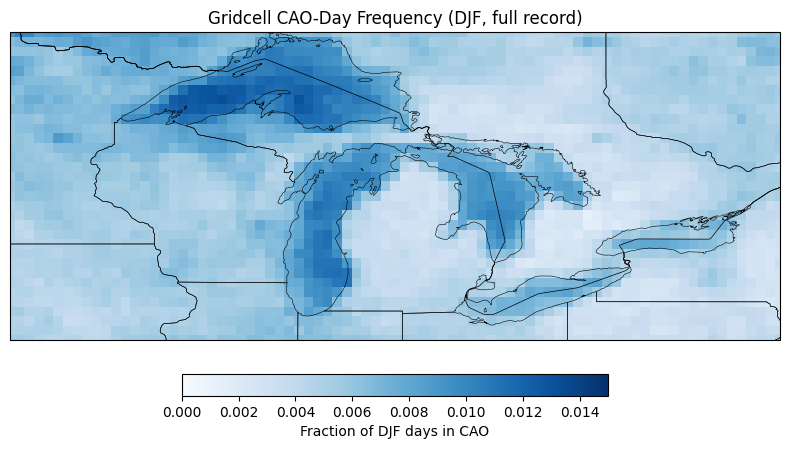

In [ ]:
#Total CAO days & frequency map
cao_flag = cold_events.astype(int).rename("cao_flag")

# Total CAO days per grid cell over the whole record
cao_days_total = cao_flag.sum(dim="time")        

# Fraction of DJF days that are CAO at each grid cell
cao_freq = cao_flag.mean(dim="time")     

print(cao_days_total.shape, cao_freq.shape)

fig = plt.figure(figsize=(8,5))
ax = plt.axes(projection=ccrs.PlateCarree())

pcm = cao_freq.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap="Blues",
    vmin=0,
    vmax=0.015, # max fraction
    cbar_kwargs={"label": "Fraction of DJF days in CAO",        
        "orientation": "horizontal",
        "pad": 0.08,        
        "fraction": 0.05}
)

ax.coastlines(resolution="10m")
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.STATES, linewidth=0.4)

ax.set_title("Gridcell CAO-Day Frequency (DJF, full record)")
ax.set_extent([cold_events.longitude.min(), cold_events.longitude.max(),
               cold_events.latitude.min(),  cold_events.latitude.max()],
              crs=ccrs.PlateCarree())

plt.tight_layout()
plt.savefig("code/figures/cao_freq_full_record.png", dpi = 300, bbox_inches="tight")
plt.show()



In [80]:
# Sum CAO days per DJF season at each grid cell
cao_days_grid = (
    cao_flag
    .groupby(season_year)   
    .sum(dim="time")       
)

cao_days_grid.head()

<xarray.DataArray 'cao_flag' (season_year: 5, latitude: 5, longitude: 5)> Size: 1kB
array([[[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]],

       [[1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]],

       [[2, 2, 2, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [2, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]]])
Coordinates:
    number       int64 8B 0
    step         timedelta64[ns] 8B 00:00:00
    surface      float64 8B 0.0
  * latitude     (latitude) float64 40B 49.0 48.75 48.5 48.25 48.0
  * longitude    (longitude) float64 40B -95.0 -94.75 -94.5 -94.25 -94.0
    quantile     float64 8B 0.05
  * season_year  (season_year) int64 40B 1940 1941 1942 1943 1944

In [84]:
# Linear trend per gridcell

# Add numeric coords
cao_days_grid = cao_days_grid.assign_coords(
    season_year_num=("season_year", cao_days_grid["season_year"].data.astype(float))
)

# 1st order polynomial fit along season_year_num
poly = cao_days_grid.polyfit(dim="season_year_num", deg=1)
trend_per_year = poly["polyfit_coefficients"].sel(degree=1)

# Convert to days / decade
trend_per_decade = (trend_per_year * 10).rename("trend_days_per_decade")

trend_per_decade


<xarray.DataArray 'trend_days_per_decade' (latitude: 33, longitude: 81)> Size: 21kB
array([[-9.43440728e-05,  1.38685787e-02,  1.03778480e-03, ...,
         3.79263173e-02,  4.72663805e-02,  3.00957592e-02],
       [ 4.22661446e-02,  5.43421860e-02,  3.06618237e-02, ...,
         3.33978018e-02,  4.10396717e-02,  4.23604887e-02],
       [ 4.12283598e-02,  4.80211331e-02,  6.10406151e-02, ...,
         4.36813057e-02,  4.50964668e-02,  3.69828766e-02],
       ...,
       [-4.05679513e-03,  8.67965470e-03,  2.59446200e-02, ...,
        -1.60384924e-03, -7.35883768e-03, -1.69819331e-03],
       [ 1.13212887e-02,  5.56630030e-03,  5.00023586e-03, ...,
         6.32105288e-03,  1.86801264e-02, -7.35883768e-03],
       [-2.78315015e-02, -6.69842917e-03,  1.98122553e-03, ...,
         1.22647295e-03, -6.88711732e-03, -9.43440728e-03]],
      shape=(33, 81))
Coordinates:
    degree     int64 8B 1
  * longitude  (longitude) float64 648B -95.0 -94.75 -94.5 ... -75.25 -75.0
  * latitude   (latitude) float64 264B 49.0 48.75 48.5 48.25 ... 41.5 41.25 41.0

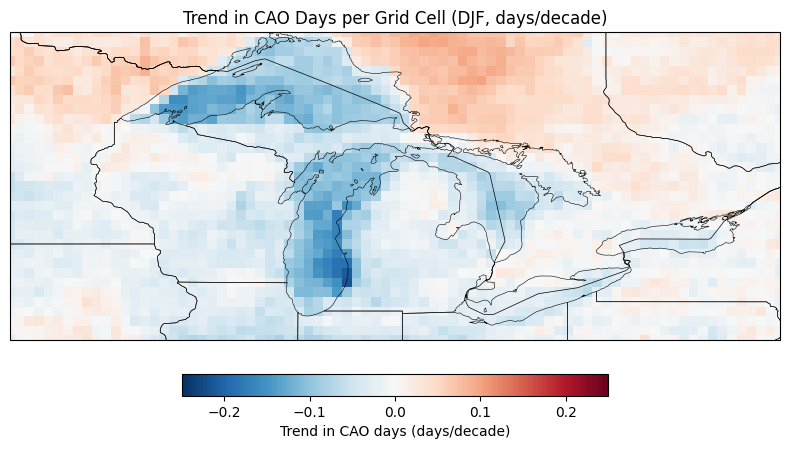

In [ ]:
# PLot trend in CAO days per grid cell 
fig = plt.figure(figsize=(8,5))
ax = plt.axes(projection=ccrs.PlateCarree())

vmax = np.nanmax(np.abs(trend_per_decade.values))
vmax = max(vmax, 0.25)   

pcm = trend_per_decade.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap="RdBu_r",
    vmin=-vmax,
    vmax= vmax,
    cbar_kwargs={"label": "Trend in CAO days (days/decade)",        
        "orientation": "horizontal",
        "pad": 0.08,        
        "fraction": 0.05}
)

ax.coastlines(resolution="10m")
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.STATES, linewidth=0.4)

ax.set_title("Trend in CAO Days per Grid Cell (DJF, days/decade)")
ax.set_extent([cold_events.longitude.min(), cold_events.longitude.max(),
               cold_events.latitude.min(),  cold_events.latitude.max()],
              crs=ccrs.PlateCarree())

plt.tight_layout()
plt.savefig("code/figures/trend_cao_days_per_gridcell_decade.png", dpi=300, bbox_inches="tight")
plt.show()


## MSL Anomalies During CAO Events

In [ ]:
# MSL Anomalies During CAO Days 

# DJF daily MSL & anomalies 

# extract msl and resample to daily means
msl = msl_gl["msl"].sortby("time")  
msl_daily = msl.resample(time="1D").mean()

# Align msl DJF t2m/cold_events time axis
msl_djf_daily = msl_daily.sel(time=t2m_djf_daily["time"])
msl_djf_daily.name = "msl_djf_daily"

print("msl_djf_daily shape:", msl_djf_daily.shape)

# Build DJF daily anomalies 
mask_base = (msl_djf_daily["time"].dt.year >= 1981) & (
    msl_djf_daily["time"].dt.year <= 2010
)
msl_base = msl_djf_daily.where(mask_base, drop=True)

# Mean DJF msl over the baseline
msl_djf_clim = msl_base.mean(dim="time")  

# Anomalies for each DJF day
msl_anom_djf_daily = msl_djf_daily - msl_djf_clim
msl_anom_djf_daily.name = "msl_anom_djf_daily"

print("MSL anomaly field:", msl_anom_djf_daily.shape)

msl_djf_daily shape: (7731, 33, 81)
MSLP anomaly field: (7731, 33, 81)


In [ ]:
# Basin-mean MSL anomalies & CAO coverage

# 2D weights 
w_2d, _ = xr.broadcast(lat_weights, msl_anom_djf_daily.longitude)

# Basin-mean msl anomaly for each DJF day
msl_anom_basin = msl_anom_djf_daily.weighted(w_2d).mean(
    dim=("latitude", "longitude")
)
msl_anom_basin.name = "msl_anom_basin"

# CAO coverage fraction 
regional_frac = regional_frac.sel(time=msl_anom_basin["time"])

# Binary CAO day mask 
cao_day_bool = regional_cao_day.sel(time=msl_anom_basin["time"]).astype(bool)

# Build daily df
df_daily = pd.DataFrame(
    {
        "msl_anom_hPa": msl_anom_basin.to_pandas(),
        "cao_frac": regional_frac.to_pandas(),       # 0–1
        "cao_day": cao_day_bool.to_pandas().astype(bool),
    }
).dropna()

# CAO days only
df_cao = df_daily[df_daily["cao_day"]].copy()
print("Number of CAO days with MSL anomalies:", len(df_cao))

Number of CAO days with MSLP anomalies: 712


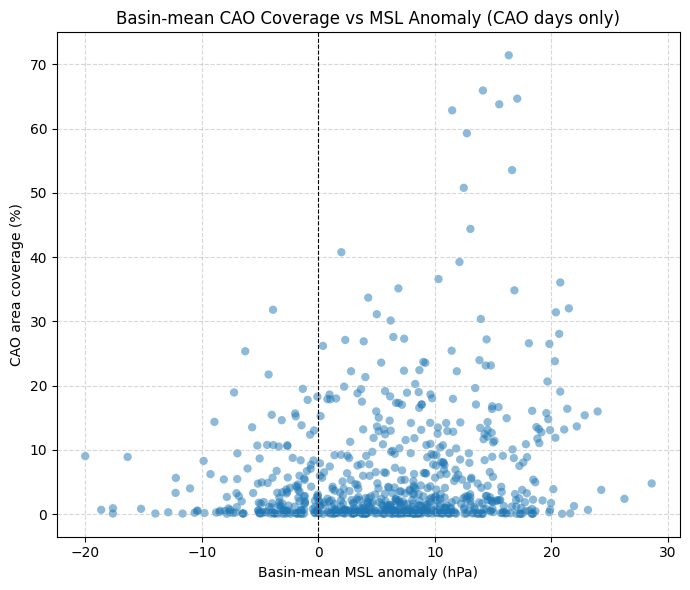

Daily CAO days: r(MSL anomaly, CAO coverage) = 0.204, p = 3.84e-08


In [91]:
# Plot of CAO coverage vs MSL anomalies

plt.figure(figsize=(7, 6))
plt.scatter(
    df_cao["msl_anom_hPa"],
    df_cao["cao_frac"] * 100.0,
    alpha=0.5,
    edgecolor="none",
)
plt.axvline(0, color="k", linestyle="--", linewidth=0.8)
plt.xlabel("Basin-mean MSL anomaly (hPa)")
plt.ylabel("CAO area coverage (%)")
plt.title("Basin-mean CAO Coverage vs MSL Anomaly (CAO days only)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig("/Users/Haley/Desktop/Capstone-2/great_lakes_capstone_2/code/figures/coverage_vs_msl_anom.png", dpi=300, bbox_inches="tight")
plt.show()

# Daily correlation
r_cov_daily, p_cov_daily = pearsonr(df_cao["msl_anom_hPa"], df_cao["cao_frac"])
print(
    f"Daily CAO days: r(MSL anomaly, CAO coverage) = "
    f"{r_cov_daily:.3f}, p = {p_cov_daily:.3g}"
)


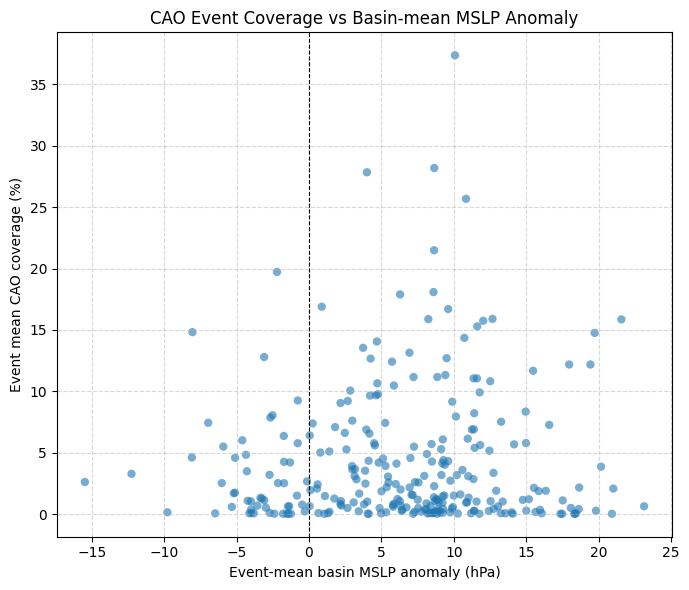

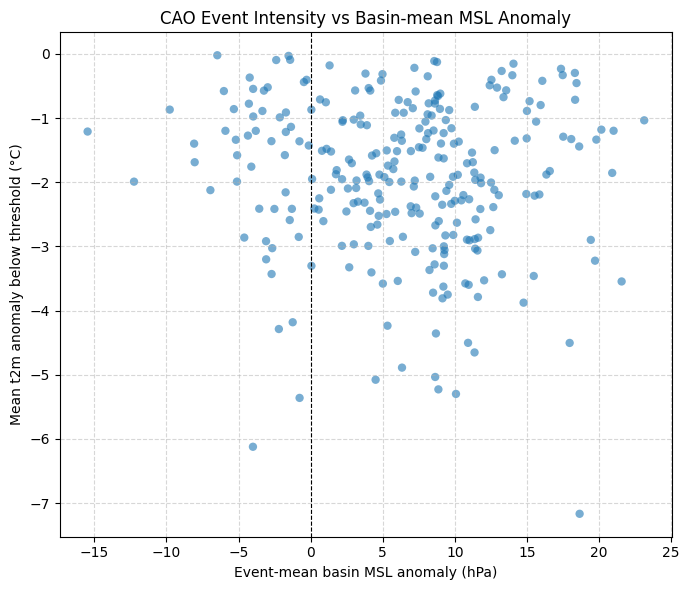


Event-level correlations:
  Coverage vs MSL anomaly:  r = 0.049, p = 0.426
  Intensity vs MSL anomaly: r = -0.081, p = 0.186


In [ ]:
# coverage / intensity vs MSL anomalies

# compute the mean basin-mean MSL anomaly for each event
event_msl_anom = []
for _, row in events_df.iterrows():
    start = pd.to_datetime(row["start"])
    end = pd.to_datetime(row["end"])
    # mean anomaly over event duration
    msl_ev = (
        msl_anom_basin.sel(time=slice(start, end)).mean().item()
    )
    event_msl_anom.append(msl_ev)

events_df["msl_anom_event"] = event_msl_anom

# scatter plot
plt.figure(figsize=(7, 6))
plt.scatter(
    events_df["msl_anom_event"],
    events_df["regional_coverage_mean"] * 100.0,
    alpha=0.6,
    edgecolor="none",
)
plt.axvline(0, color="k", linestyle="--", linewidth=0.8)
plt.xlabel("Event-mean basin MSL anomaly (hPa)")
plt.ylabel("Event mean CAO coverage (%)")
plt.title("CAO Event Coverage vs Basin-mean MSL Anomaly")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig("code/figures/coverage_vs_msl_anom_2.png", dpi=300, bbox_inches="tight")
plt.show()

# Scatter: event intensity vs MSL anomaly
plt.figure(figsize=(7, 6))
plt.scatter(
    events_df["msl_anom_event"],
    events_df["mean_temp_below_thr"],   # °C deficit (negative = colder)
    alpha=0.6,
    edgecolor="none",
)
plt.axvline(0, color="k", linestyle="--", linewidth=0.8)
plt.xlabel("Event-mean basin MSL anomaly (hPa)")
plt.ylabel("Mean t2m anomaly below threshold (°C)")
plt.title("CAO Event Intensity vs Basin-mean MSL Anomaly")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig("code/figures/mean_basin_msl_anom_2.png", dpi=300, bbox_inches="tight")
plt.show()

# Event-level correlations
r_cov_evt, p_cov_evt = pearsonr(
    events_df["msl_anom_event"], events_df["regional_coverage_mean"]
)
r_int_evt, p_int_evt = pearsonr(
    events_df["msl_anom_event"], events_df["mean_temp_below_thr"]
)

print("\nEvent-level correlations:")
print(
    f"  Coverage vs MSL anomaly:  r = {r_cov_evt:.3f}, "
    f"p = {p_cov_evt:.3g}"
)
print(
    f"  Intensity vs MSL anomaly: r = {r_int_evt:.3f}, "
    f"p = {p_int_evt:.3g}"
)


In [93]:
# CAO metrics vs basin-mean MSL anomalies

# Basin-mean seasonal MSL anomaly 
msl_anom_season = (
    msl_anom_basin.groupby(season_year).mean("time").to_pandas()
)
msl_anom_season.name = "msl_anom_basin"

# Merge with CAO seasonal summary 
df_season = (
    cao_summary.join(msl_anom_season, how="inner")
    .dropna()
    .sort_index()
)

print("\nSeasonal dataframe (head):")
print(df_season.head())

metrics = ["n_events", "cao_days", "mean_daily_coverage"]
print("\nSeasonal correlations with basin-mean DJF MSL anomaly:")
for m in metrics:
    r, p = pearsonr(df_season[m], df_season["msl_anom_basin"])
    print(f"  {m} vs MSL anomaly: r = {r:.3f}, p = {p:.3g}")


Seasonal dataframe (head):
             n_events  cao_days  mean_daily_coverage  msl_anom_basin
season_year                                                         
1940              3.0        10             0.005857        0.349810
1941              3.0         4             0.000874        2.116015
1942              5.0        15             0.005760        1.523505
1943              5.0        14             0.002119        0.762136
1944              2.0         2             0.000047        1.792892

Seasonal correlations with basin-mean DJF MSL anomaly:
  n_events vs MSL anomaly: r = 0.321, p = 0.00257
  cao_days vs MSL anomaly: r = 0.251, p = 0.0197
  mean_daily_coverage vs MSL anomaly: r = 0.110, p = 0.315


## MSL Composites

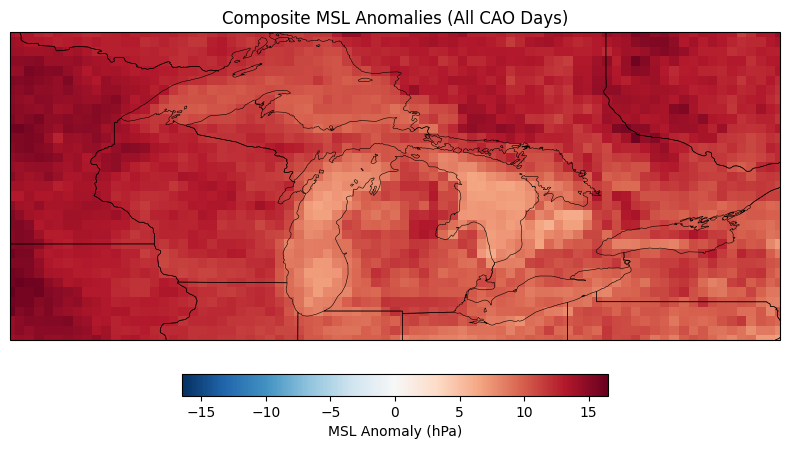

In [ ]:
# Daily DJF MSL anomalies 
msl_d = msl_gl["msl"].resample(time="1D").mean()
is_djf = msl_d["time"].dt.month.isin([12, 1, 2])
msl_djf_daily = msl_d.where(is_djf, drop=True)

# Monthly climatology
msl_mon = msl_gl["msl"].resample(time="MS").mean()
msl_base = msl_mon.sel(time=slice("1981-01-01", "2010-12-31"))
msl_clim_mon = msl_base.groupby("time.month").mean("time")  # (month, lat, lon)

# Daily anoms
msl_anom_daily = msl_djf_daily.groupby("time.month") - msl_clim_mon

# Align CAO mask to MSL time axis
common_time = np.intersect1d(msl_anom_daily.time.values, cold_events.time.values)
msl_anom_daily = msl_anom_daily.sel(time=common_time)
cold_events_aligned = cold_events.sel(time=common_time)

# Composite over all CAO days
msl_composite = msl_anom_daily.where(cold_events_aligned).mean("time")

# plot
fig = plt.figure(figsize=(8, 5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon_min, lon_max, lat_min, lat_max])

vlim = float(np.nanmax(np.abs(msl_composite.values)))
msl_composite.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap="RdBu_r",
    vmin=-vlim, vmax=vlim,
    add_colorbar=True,
    cbar_kwargs={
        "label": "MSL Anomaly (hPa)",
        "orientation": "horizontal",
        "pad": 0.08,
        "fraction": 0.05
    },
)

ax.coastlines()
ax.add_feature(cfeature.STATES, linewidth=0.4)
ax.set_title("Composite MSL Anomalies (All CAO Days)")
plt.tight_layout()
plt.savefig("code/figures/composite_msl_anom_all_cao_days.png",dpi=300, bbox_inches="tight")
plt.show()


In [94]:
# MSL Composites by Cluster 

msl = msl_gl["msl"].sortby("time")

# Daily means
msl_d = msl.resample(time="1D").mean()

# DJF days only
is_djf_msl = msl_d["time"].dt.month.isin([12, 1, 2])
msl_djf_daily = msl_d.where(is_djf_msl, drop=True)

#  DJF climatology over the full record
msl_djf_clim = msl_djf_daily.mean("time")
msl_djf_anom = msl_djf_daily - msl_djf_clim

msl_djf_anom = msl_djf_anom.sel(time=t2m_djf_daily.time)

# MSL anomaly maps per event 

msl_event_maps = [] 

for i, row in events_df.iterrows():
    start = row["start"]
    end   = row["end"]

    # Boolean mask for CAO days 
    event_mask = (
        (msl_djf_anom["time"] >= np.datetime64(start)) &
        (msl_djf_anom["time"] <= np.datetime64(end))
    )

    # Mean MSL anomaly over all event days 
    msl_event_mean = msl_djf_anom.sel(time=event_mask).mean("time")
    msl_event_maps.append(msl_event_mean)


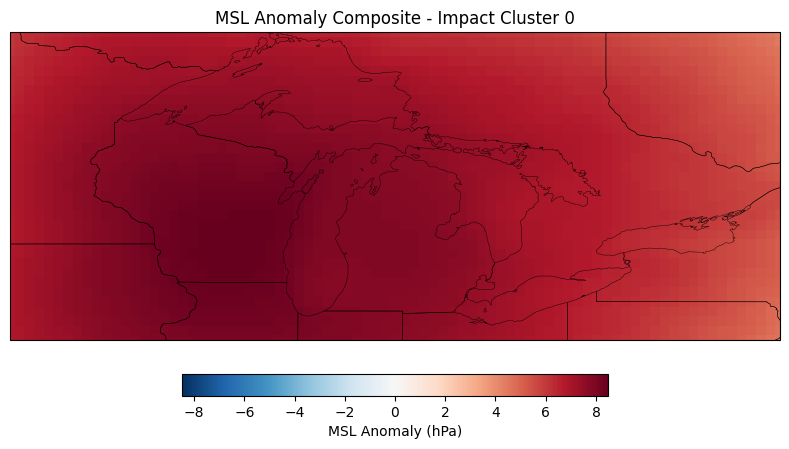

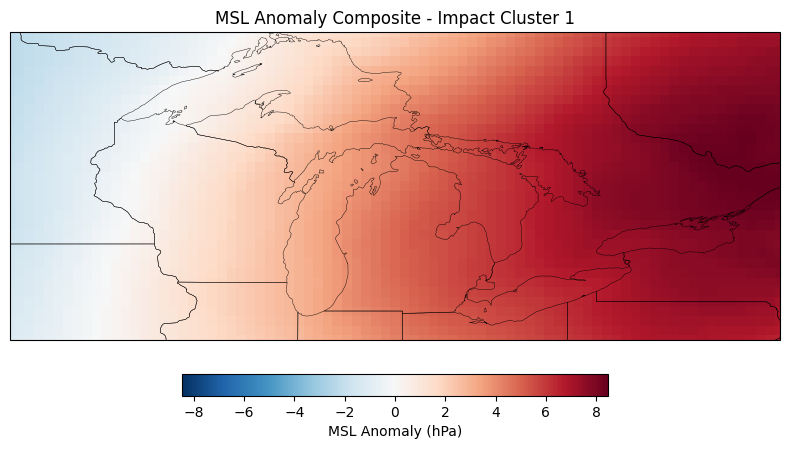

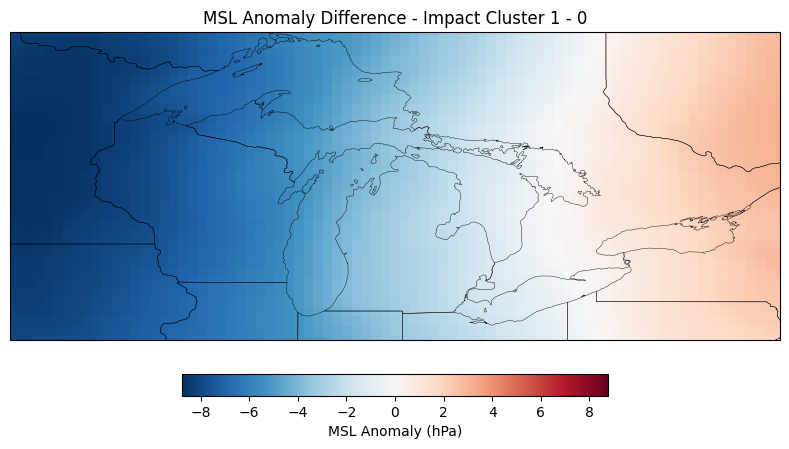

In [ ]:
# Impact-cluster MSL composites

impact_clusters = sorted(events_df["cluster"].unique())
impact_msl_composites = {}

for cl in impact_clusters:
    group_maps = [
        msl_event_maps[i]
        for i in range(len(msl_event_maps))
        if events_df["cluster"].iloc[i] == cl
    ]
    if len(group_maps) == 0:
        continue

    composite = xr.concat(group_maps, dim="event").mean("event")
    impact_msl_composites[cl] = composite

    # Plot composite map
    fig = plt.figure(figsize=(8, 5))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([-95, -75, 41, 49])

    im = composite.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap="RdBu_r",
        center=0.0,           
        add_colorbar=True,
        cbar_kwargs={
            "orientation": "horizontal",
            "pad": 0.08,
            "fraction": 0.05,
            "label": "MSL Anomaly (hPa)"
        }
    )
    ax.coastlines()
    ax.add_feature(cfeature.STATES, linewidth=0.3)
    ax.set_title(f"MSL Anomaly Composite - Impact Cluster {cl}")
    plt.tight_layout()
    plt.savefig(f"code/figures/impact_cluster_{cl}_msl_composite.png", dpi=300, bbox_inches="tight")
    plt.show()

# impact cluster 1 − cluster 0 
if 0 in impact_msl_composites and 1 in impact_msl_composites:
    impact_diff = impact_msl_composites[1] - impact_msl_composites[0]

    fig = plt.figure(figsize=(8, 5))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([-95, -75, 41, 49])

    impact_diff.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap="RdBu_r",
        center=0.0,
        add_colorbar=True,
        cbar_kwargs={
            "orientation": "horizontal",
            "pad": 0.08,
            "fraction": 0.05,
            "label": "MSL Anomaly (hPa)"
        }
    )
    ax.coastlines()
    ax.add_feature(cfeature.STATES, linewidth=0.3)
    ax.set_title("MSL Anomaly Difference - Impact Cluster 1 - 0")
    plt.tight_layout()
    plt.savefig("code/figures/impact_cluster_diff_msl_composite.png", dpi=300, bbox_inches="tight")
    plt.show()


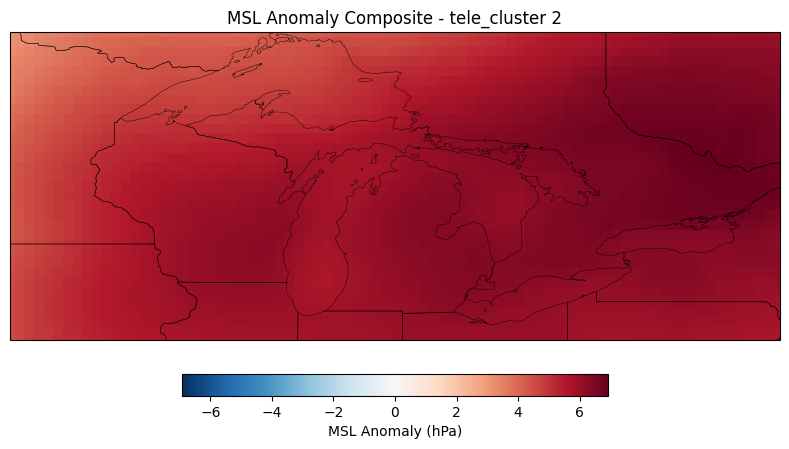

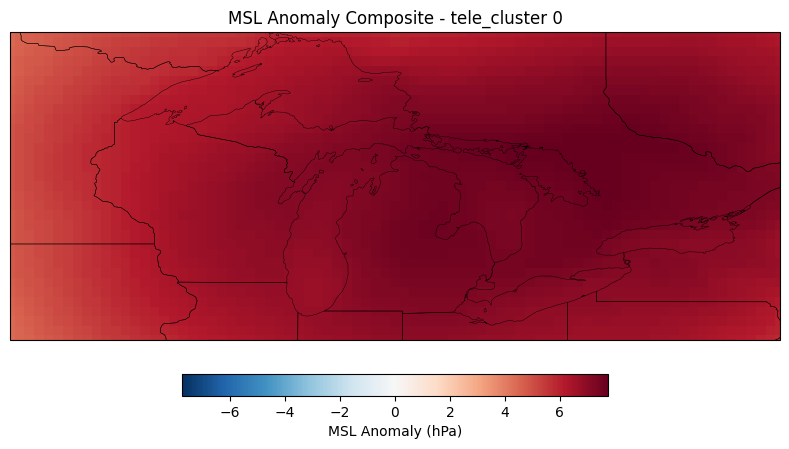

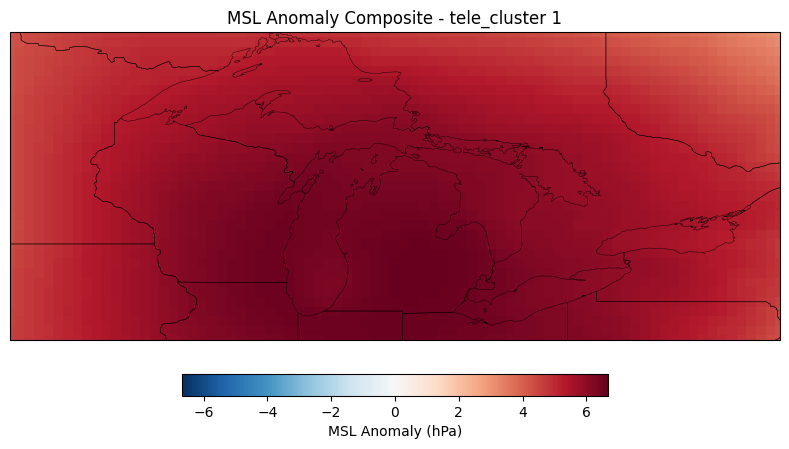

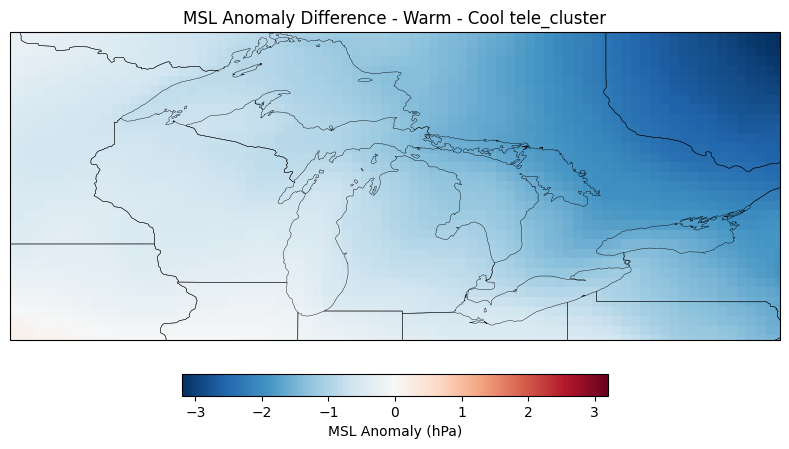

In [97]:
# Teleconnection-cluster MSL composites 

tele_clusters = (
    events_df["tele_cluster"]
    .dropna()
    .unique()
    .tolist()
)

tele_msl_composites = {}

for tcl in tele_clusters:
    # mask of events 
    mask = (events_df["tele_cluster"].notna()) & (events_df["tele_cluster"] == tcl)
    idx = np.where(mask)[0]

    group_maps = [msl_event_maps[i] for i in idx]
    if len(group_maps) == 0:
        continue

    composite = xr.concat(group_maps, dim="event").mean("event")
    tele_msl_composites[int(tcl)] = composite

    # Plot composite map
    fig = plt.figure(figsize=(8, 5))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([-95, -75, 41, 49])

    composite.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap="RdBu_r",
        center=0.0,
        add_colorbar=True,
        cbar_kwargs={
            "orientation": "horizontal",
            "pad": 0.08,
            "fraction": 0.05,
            "label": "MSL Anomaly (hPa)"
        }
    )
    ax.coastlines()
    ax.add_feature(cfeature.STATES, linewidth=0.3)
    ax.set_title(f"MSL Anomaly Composite - tele_cluster {int(tcl)}")
    plt.tight_layout()
    plt.savefig(f"/Users/Haley/Desktop/Capstone-2/great_lakes_capstone_2/code/figures/tele_cluster_{cl}_msl_composite.png", dpi=300, bbox_inches="tight")
    plt.show()

# warm − cool tele_cluster map
if 0 in tele_msl_composites and 1 in tele_msl_composites:
    tele_diff = tele_msl_composites[1] - tele_msl_composites[0]

    fig = plt.figure(figsize=(8, 5))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([-95, -75, 41, 49])

    tele_diff.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap="RdBu_r",
        center=0.0,
        add_colorbar=True,
        cbar_kwargs={
            "orientation": "horizontal",
            "pad": 0.08,
            "fraction": 0.05,
            "label": "MSL Anomaly (hPa)"
        }
    )
    ax.coastlines()
    ax.add_feature(cfeature.STATES, linewidth=0.3)
    ax.set_title("MSL Anomaly Difference - Warm - Cool tele_cluster")
    plt.tight_layout()
    plt.savefig("/Users/Haley/Desktop/Capstone-2/great_lakes_capstone_2/code/figures/tele_cluster_diff_msl_composite.png", dpi=300, bbox_inches="tight")
    plt.show()



## CAO Composites

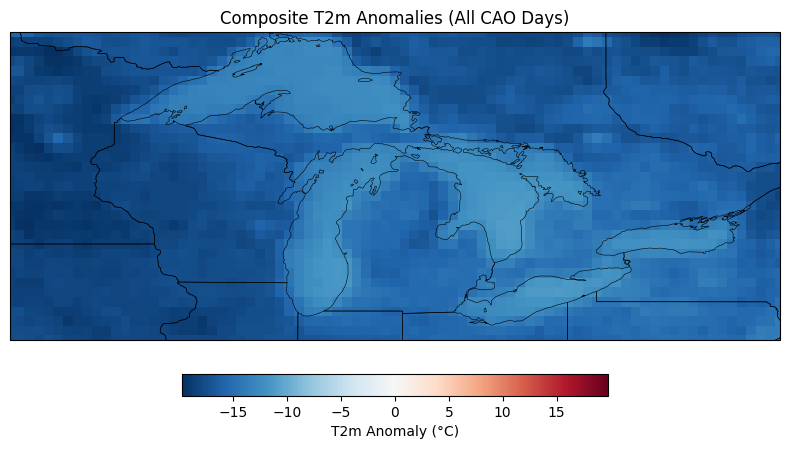

In [ ]:
# Daily DJF t2m anomalies
t2m_d = t2m_gl["t2m"].resample(time="1D").mean()

is_djf = t2m_d["time"].dt.month.isin([12, 1, 2])
t2m_djf_daily = t2m_d.where(is_djf, drop=True)

# monthly climatology
t2m_mon = t2m_gl["t2m"].resample(time="MS").mean()
t2m_base = t2m_mon.sel(time=slice("1981-01-01", "2010-12-31"))
t2m_clim_mon = t2m_base.groupby("time.month").mean("time")  # (month, lat, lon)

# Daily anoms
t2m_anom_daily = t2m_djf_daily.groupby("time.month") - t2m_clim_mon

# Align CAO mask to t2m time axis
common_time = np.intersect1d(t2m_anom_daily.time.values, cold_events.time.values)
t2m_anom_daily = t2m_anom_daily.sel(time=common_time)
cold_events_aligned = cold_events.sel(time=common_time)

# Composite over all CAO days
t2m_composite = t2m_anom_daily.where(cold_events_aligned).mean("time")

# plot
fig = plt.figure(figsize=(8, 5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon_min, lon_max, lat_min, lat_max])

vlim = float(np.nanmax(np.abs(t2m_composite.values)))
t2m_composite.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap="RdBu_r",
    vmin=-vlim, vmax=vlim,
    add_colorbar=True,
    cbar_kwargs={
        "label": "T2m Anomaly (°C)",
        "orientation": "horizontal",
        "pad": 0.08,
        "fraction": 0.05
    },
)

ax.coastlines()
ax.add_feature(cfeature.STATES, linewidth=0.4)
ax.set_title("Composite T2m Anomalies (All CAO Days)")
plt.tight_layout()
plt.savefig("code/figures/composite_t2m_anom_all_cao_days.png",dpi=300, bbox_inches="tight")
plt.show()


In [98]:
# Per-event CAO fraction maps
cao_event_maps = []  
for i, row in events_df.iterrows():
    start = np.datetime64(row["start"])
    end   = np.datetime64(row["end"])
    
    event_mask = (cold_events["time"] >= start) & (cold_events["time"] <= end)
    
    # Fraction of event days in CAO at each gridcell
    frac_map = cold_events.sel(time=event_mask).mean("time")
    frac_map.name = "cao_frac"
    cao_event_maps.append(frac_map)

print(f"Built {len(cao_event_maps)} CAO event maps")

Built 270 CAO event maps


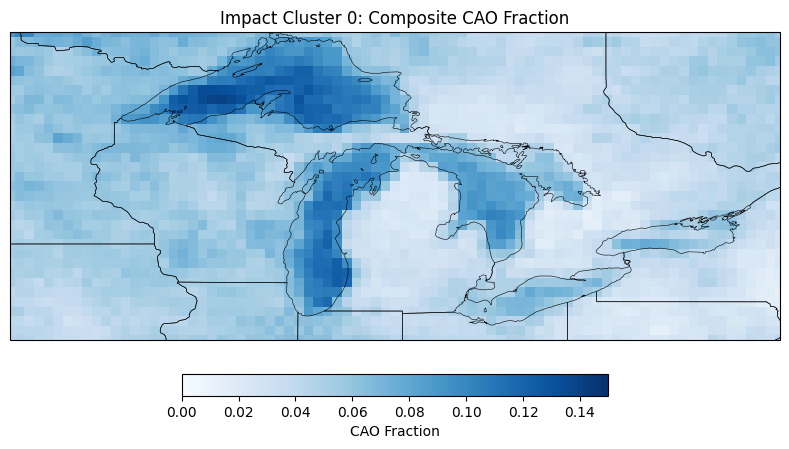

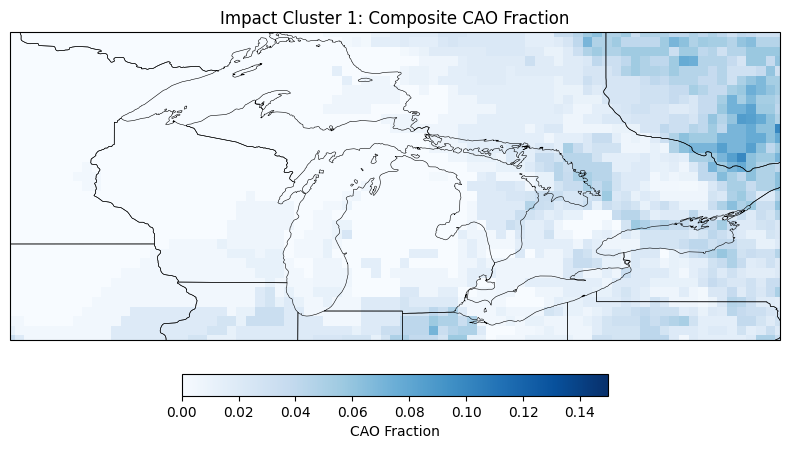

In [ ]:
#Impact cluster composites
impact_col = "impact_cluster" if "impact_cluster" in events_df.columns else "cluster"

impact_clusters = (
    events_df[impact_col]
    .dropna()
    .astype(int)
    .unique()
)
impact_clusters = np.sort(impact_clusters)

impact_cao_composites = {}

# loop through clusters and plot
for cl in impact_clusters:
    idx = events_df.index[events_df[impact_col] == cl].tolist()
    if len(idx) == 0:
        continue
    
    group_maps = [cao_event_maps[i] for i in idx]
    composite = xr.concat(group_maps, dim="event").mean("event")
    composite.name = "cao_frac"
    impact_cao_composites[cl] = composite
    
    # Plot composite
    fig = plt.figure(figsize=(8,5))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([-95, -75, 41, 49])
    
    # CAO fraction is between 0 and 1; adjust vmax if needed
    composite.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap="Blues",
        vmin=0.0,
        vmax=0.15,
        add_colorbar=True,
        cbar_kwargs={
            "orientation": "horizontal",
            "pad": 0.08,
            "fraction": 0.05,
            "label": "CAO Fraction"
        }
    )
    ax.coastlines()
    ax.add_feature(cfeature.STATES, linewidth=0.4)
    ax.set_title(f"Impact Cluster {cl}: Composite CAO Fraction")
    plt.tight_layout()
    plt.savefig(f"code/figures/cao_frac_impact_cluster{cl}_composite.png", dpi=300, bbox_inches="tight")
    plt.show()


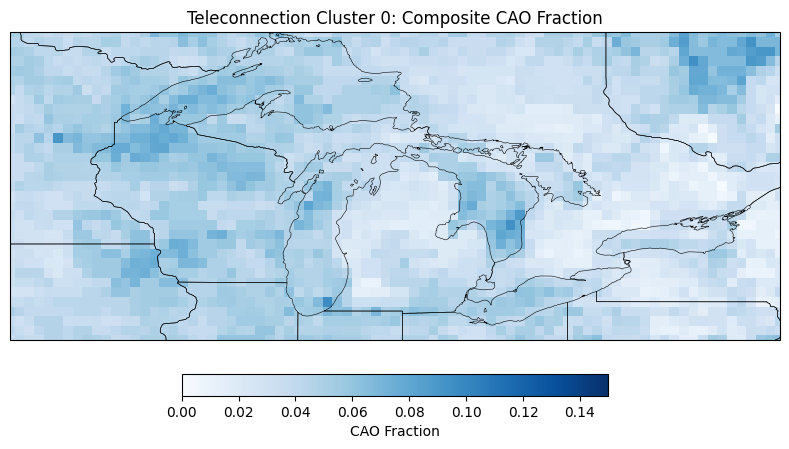

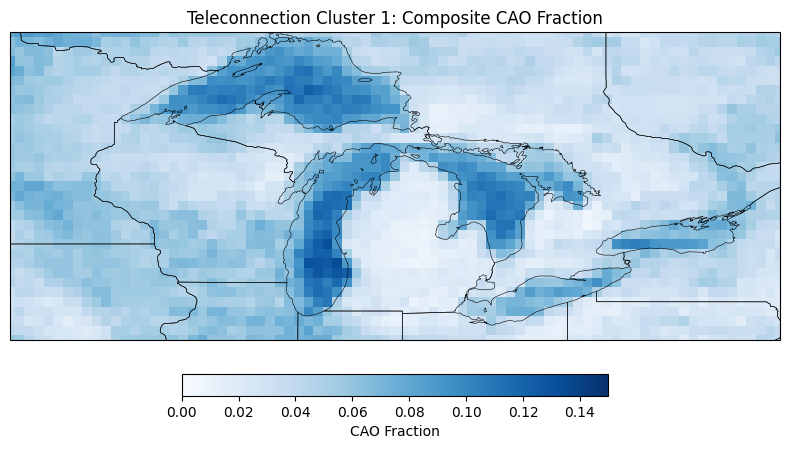

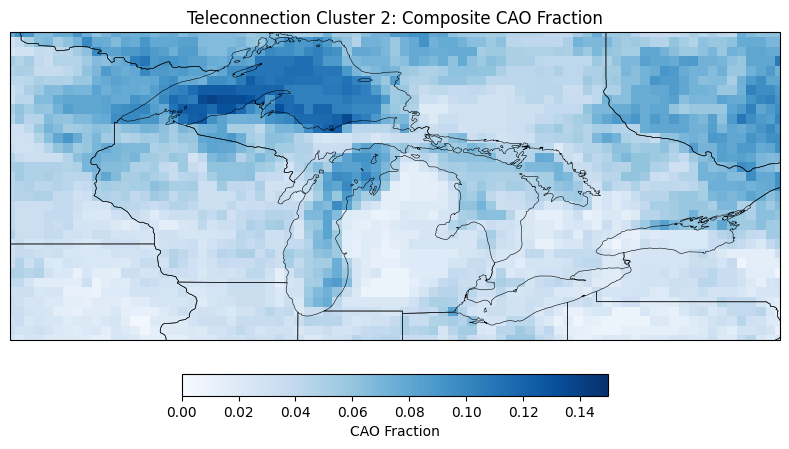

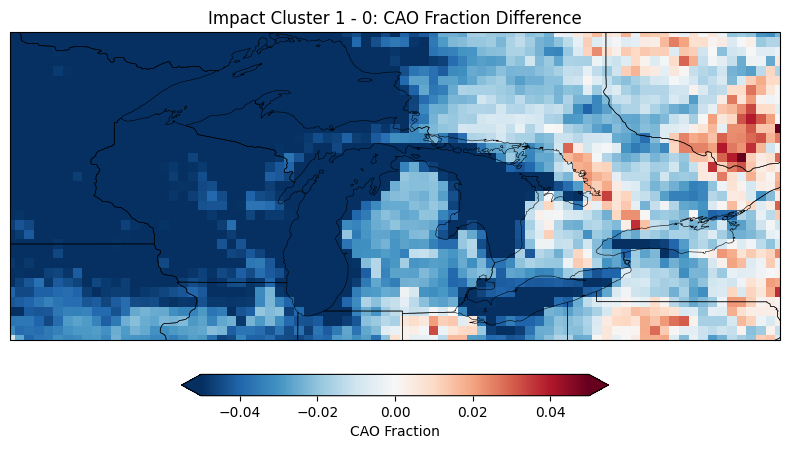

In [ ]:
# Tele cluster composites
if "tele_cluster" in events_df.columns:
    tele_valid = events_df["tele_cluster"].dropna().astype(int)
    tele_clusters = np.sort(tele_valid.unique())
else:
    tele_clusters = []

tele_cao_composites = {}

# loop through tele clusters and plot
for tcl in tele_clusters:
    idx = events_df.index[events_df["tele_cluster"] == tcl].tolist()
    if len(idx) == 0:
        continue
    
    group_maps = [cao_event_maps[i] for i in idx]
    composite = xr.concat(group_maps, dim="event").mean("event")
    composite.name = "cao_frac"
    tele_cao_composites[tcl] = composite
    
    fig = plt.figure(figsize=(8,5))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([-95, -75, 41, 49])
    
    composite.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap="Blues",
        vmin=0.0,
        vmax=0.15,
        add_colorbar=True,
        cbar_kwargs={
            "orientation": "horizontal",
            "pad": 0.08,
            "fraction": 0.05,
            "label": "CAO Fraction"
        }
    )
    ax.coastlines()
    ax.add_feature(cfeature.STATES, linewidth=0.4)
    ax.set_title(f"Teleconnection Cluster {tcl}: Composite CAO Fraction")
    plt.tight_layout()
    plt.savefig(f"code/figures/cao_frac_tele_cluster{cl}_composite.png", dpi=300, bbox_inches="tight")
    plt.show()

# difference map impact cluster 1 - 0
if 0 in impact_cao_composites and 1 in impact_cao_composites:
    diff_impact = impact_cao_composites[1] - impact_cao_composites[0]
    
    fig = plt.figure(figsize=(8,5))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([-95, -75, 41, 49])
    diff_impact.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap="RdBu_r",
        vmin=-0.05,
        vmax=0.05,
        add_colorbar=True,
        cbar_kwargs={
            "orientation": "horizontal",
            "pad": 0.08,
            "fraction": 0.05,
            "label": "CAO Fraction"
        }
    )
    ax.coastlines()
    ax.add_feature(cfeature.STATES, linewidth=0.4)
    ax.set_title("Impact Cluster 1 - 0: CAO Fraction Difference")
    plt.tight_layout()
    plt.savefig("code/figures/cao_frac_tele_cluster_diff_composite.png", dpi=300, bbox_inches="tight")
    plt.show()


## Z500 Composites

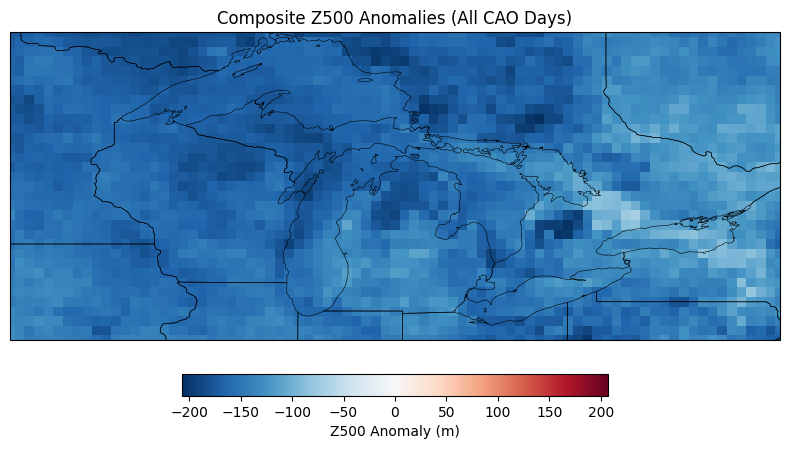

In [ ]:
# Daily DJF Z500 anomalies
z500_d = z500_gl.resample(time="1D").mean()
is_djf = z500_d["time"].dt.month.isin([12, 1, 2])
z500_djf_daily = z500_d.where(is_djf, drop=True)

# Monthly climatology
z500_mon = z500_gl.resample(time="MS").mean()
z500_base = z500_mon.sel(time=slice("1981-01-01", "2010-12-31"))
z500_clim_mon = z500_base.groupby("time.month").mean("time")  # (month, lat, lon)

# Daily anoms
z500_anom_daily = z500_djf_daily.groupby("time.month") - z500_clim_mon

# Align CAO mask to Z500 time axis
common_time = np.intersect1d(z500_anom_daily.time.values, cold_events.time.values)
z500_anom_daily = z500_anom_daily.sel(time=common_time)
cold_events_aligned = cold_events.sel(time=common_time)

# Composite over all CAO days
z500_composite = z500_anom_daily.where(cold_events_aligned).mean("time")

# plot
fig = plt.figure(figsize=(8, 5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon_min, lon_max, lat_min, lat_max])

vlim = float(np.nanmax(np.abs(z500_composite.values)))
z500_composite.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap="RdBu_r",
    vmin=-vlim, vmax=vlim,
    add_colorbar=True,
    cbar_kwargs={
        "label": "Z500 Anomaly (m)",
        "orientation": "horizontal",
        "pad": 0.08,
        "fraction": 0.05
    },
)

ax.coastlines()
ax.add_feature(cfeature.STATES, linewidth=0.4)
ax.set_title("Composite Z500 Anomalies (All CAO Days)")
plt.tight_layout()
plt.savefig("ode/figures/composite_z500_anom_all_cao_days.png",dpi=300, bbox_inches="tight")
plt.show()


Built 270 Z500 event maps


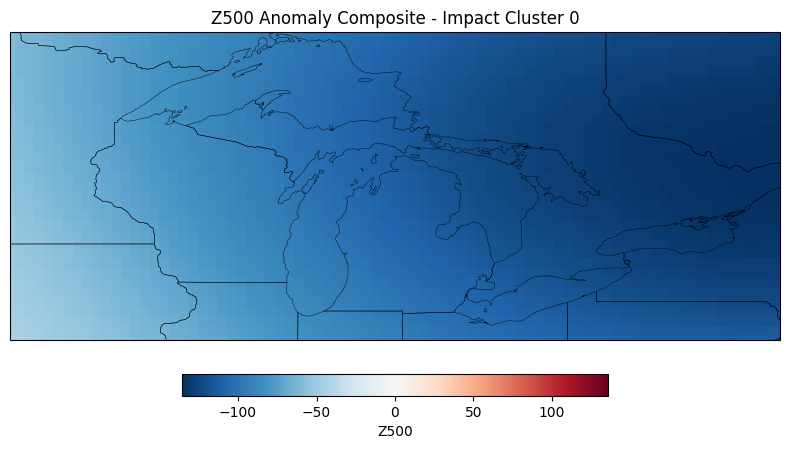

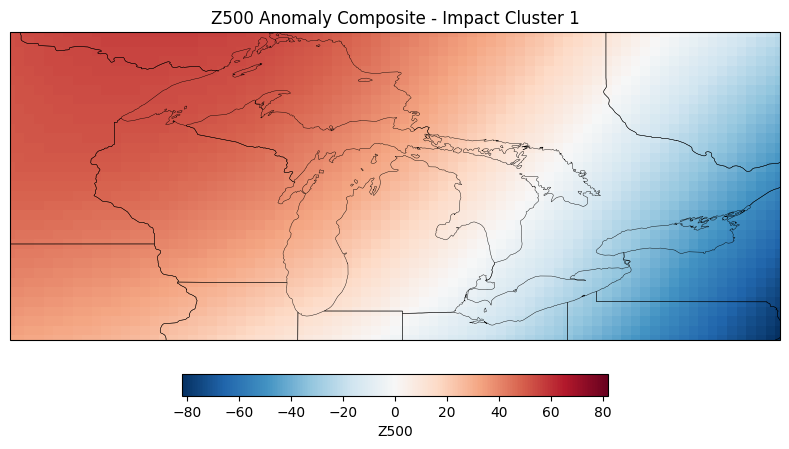

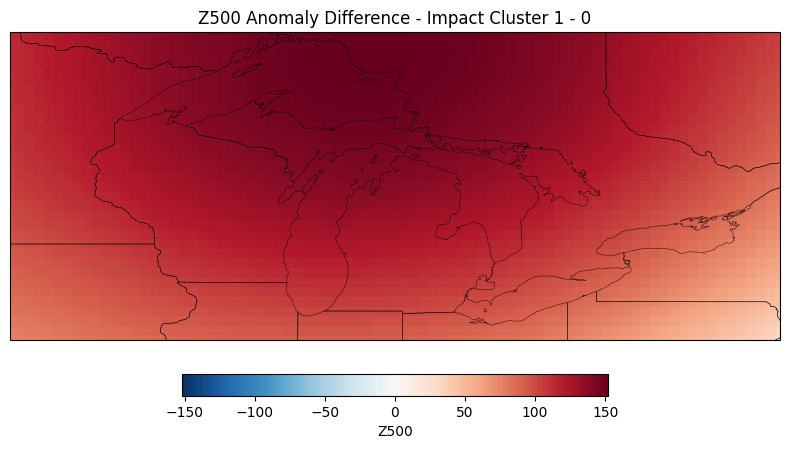

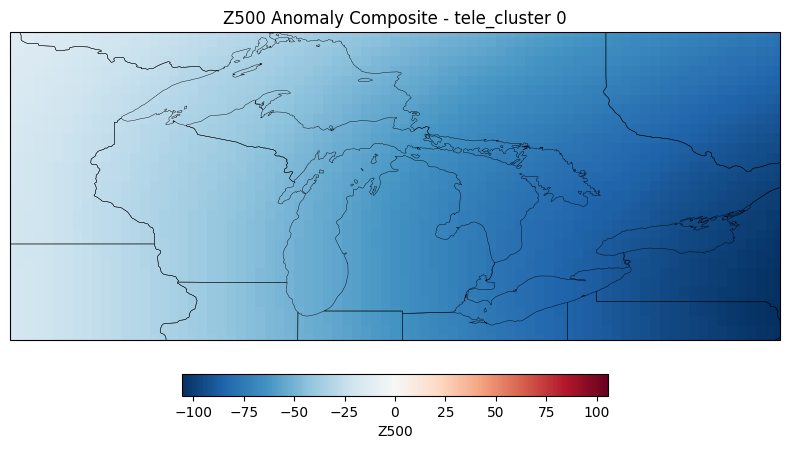

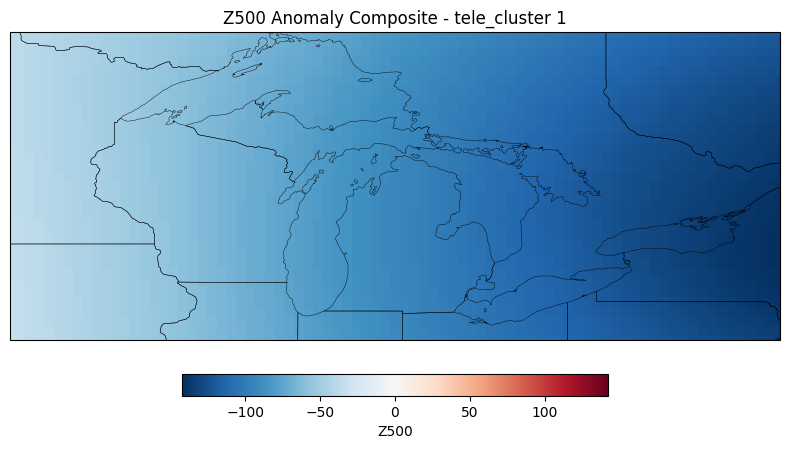

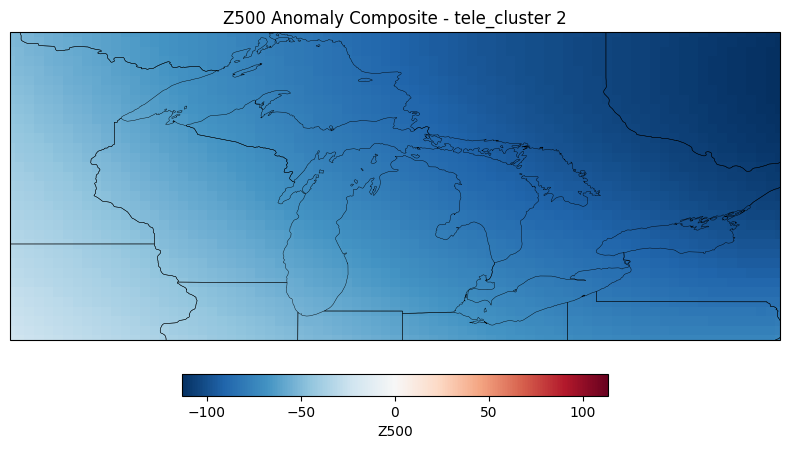

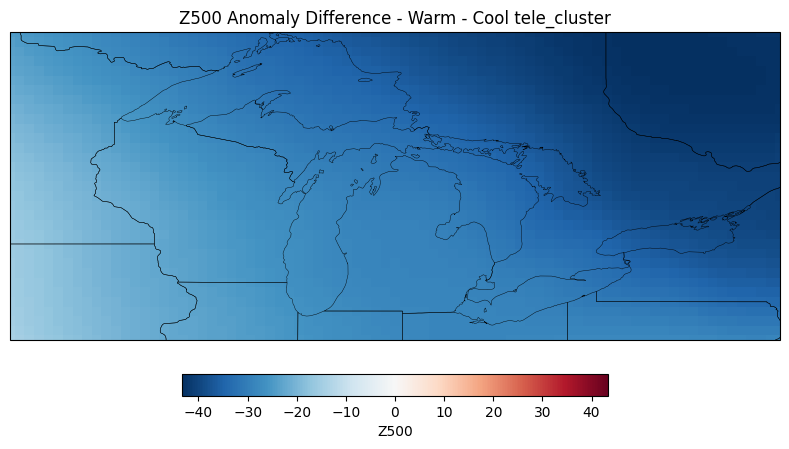

In [ ]:
# Per-event Z500 anomaly composite

z500_event_maps = []  
for i, row in events_df.iterrows():
    start = row["start"]
    end = row["end"]

    event_mask = (
        (z500_djf_anom["time"] >= np.datetime64(start)) &
        (z500_djf_anom["time"] <= np.datetime64(end))
    )

    z500_event_mean = z500_djf_anom.sel(time=event_mask).mean("time")
    z500_event_maps.append(z500_event_mean)

print(f"Built {len(z500_event_maps)} Z500 event maps")

# Impact cluster Z500 composites 
impact_clusters = sorted(events_df["cluster"].unique())
impact_z500_composites = {}

for cl in impact_clusters:
    idx = [i for i in range(len(z500_event_maps))
           if events_df["cluster"].iloc[i] == cl]
    if len(idx) == 0:
        continue

    group_maps = [z500_event_maps[i] for i in idx]
    composite = xr.concat(group_maps, dim="event").mean("event")
    impact_z500_composites[cl] = composite

    fig = plt.figure(figsize=(8, 5))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([-95, -75, 41, 49])
    composite.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap="RdBu_r",
        center=0.0,
        add_colorbar=True,
        cbar_kwargs={
            "orientation": "horizontal",
            "pad": 0.08,
            "fraction": 0.05,
            "label": "Z500"
        }
    )
    ax.coastlines()
    ax.add_feature(cfeature.STATES, linewidth=0.3)
    ax.set_title(f"Z500 Anomaly Composite - Impact Cluster {cl}")
    plt.tight_layout()
    plt.savefig(f"code/figures/z_impact_cluster_{cl}_composite.png", dpi=300, bbox_inches="tight")
    plt.show()

# difference map (cluster 1 − 0)
if 0 in impact_z500_composites and 1 in impact_z500_composites:
    impact_z500_diff = impact_z500_composites[1] - impact_z500_composites[0]

    fig = plt.figure(figsize=(8, 5))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([-95, -75, 41, 49])
    impact_z500_diff.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap="RdBu_r",
        center=0.0,
        add_colorbar=True,
        cbar_kwargs={
            "orientation": "horizontal",
            "pad": 0.08,
            "fraction": 0.05,
            "label": "Z500"
        }
    )
    ax.coastlines()
    ax.add_feature(cfeature.STATES, linewidth=0.3)
    ax.set_title("Z500 Anomaly Difference - Impact Cluster 1 - 0")
    plt.tight_layout()
    plt.savefig("code/figures/z_impact_cluster_diff_composite.png", dpi=300, bbox_inches="tight")
    plt.show()

# Teleconnection cluster Z500 composites 
tele_z500_composites = {}
if "tele_cluster" in events_df.columns:
    tele_valid = events_df["tele_cluster"].dropna().astype(int)
    tele_clusters = np.sort(tele_valid.unique())
else:
    tele_clusters = []

for tcl in tele_clusters:
    mask = (events_df["tele_cluster"].notna()) & (events_df["tele_cluster"] == tcl)
    idx = np.where(mask)[0]
    if len(idx) == 0:
        continue

    group_maps = [z500_event_maps[i] for i in idx]
    composite = xr.concat(group_maps, dim="event").mean("event")
    tele_z500_composites[int(tcl)] = composite

    fig = plt.figure(figsize=(8, 5))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([-95, -75, 41, 49])
    composite.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap="RdBu_r",
        center=0.0,
        add_colorbar=True,
        cbar_kwargs={
            "orientation": "horizontal",
            "pad": 0.08,
            "fraction": 0.05,
            "label": "Z500"
        }
    )
    ax.coastlines()
    ax.add_feature(cfeature.STATES, linewidth=0.3)
    ax.set_title(f"Z500 Anomaly Composite - tele_cluster {int(tcl)}")
    plt.tight_layout()
    plt.savefig(f"code/figures/z_tele_cluster_{cl}_composite.png", dpi=300, bbox_inches="tight")
    plt.show()

# Warm – cool difference 0=cool 1=warm
if 0 in tele_z500_composites and 1 in tele_z500_composites:
    tele_z500_diff = tele_z500_composites[1] - tele_z500_composites[0]

    fig = plt.figure(figsize=(8, 5))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([-95, -75, 41, 49])
    tele_z500_diff.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap="RdBu_r",
        center=0.0,
        add_colorbar=True,
        cbar_kwargs={
            "orientation": "horizontal",
            "pad": 0.08,
            "fraction": 0.05,
            "label": "Z500"
        }
    )
    ax.coastlines()
    ax.add_feature(cfeature.STATES, linewidth=0.3)
    ax.set_title("Z500 Anomaly Difference - Warm - Cool tele_cluster")
    plt.tight_layout()
    plt.savefig("code/figures/z_tele_cluster_diff_composite.png", dpi=300, bbox_inches="tight")
    plt.show()


## Diagnostic Plots & Tables

In [ ]:
# Final Diagnostic Plots & Tables
os.makedirs("output", exist_ok=True)
os.makedirs("figures", exist_ok=True)

In [ ]:
# Summary table: event counts, duration, intensity, coverage by impact cluster and tele_cluster
impact_col = "impact_cluster" if "impact_cluster" in events_df.columns else "cluster"

#Impact clusters 
cluster_summary = (
    events_df
    .dropna(subset=[impact_col])  
    .groupby(impact_col)
    .agg(
        n_events=("duration_days", "size"),
        mean_duration_days=("duration_days", "mean"),
        median_duration_days=("duration_days", "median"),
        mean_coverage=("regional_coverage_mean", "mean"),
        median_coverage=("regional_coverage_mean", "median"),
        mean_intensity=("mean_temp_below_thr", "mean"),
        median_intensity=("mean_temp_below_thr", "median"),
    )
)

# print impact cluster summary
print("\nImpact-cluster event summary:")
print(cluster_summary)

# Teleconnection clusters
if "tele_cluster" in events_df.columns:
    telecluster_summary = (
        events_df
        .dropna(subset=["tele_cluster"])
        .groupby("tele_cluster")
        .agg(
            n_events=("duration_days", "size"),
            mean_duration_days=("duration_days", "mean"),
            median_duration_days=("duration_days", "median"),
            mean_coverage=("regional_coverage_mean", "mean"),
            median_coverage=("regional_coverage_mean", "median"),
            mean_intensity=("mean_temp_below_thr", "mean"),
            median_intensity=("mean_temp_below_thr", "median"),
        )
    )
else:
    telecluster_summary = pd.DataFrame()
    print("\nWARNING: tele_cluster column not found in events_df; telecluster_summary is empty.")

print("\nTele-cluster event summary:")
print(telecluster_summary)



Impact-cluster event summary:
         n_events  mean_duration_days  median_duration_days  mean_coverage  \
cluster                                                                      
0             202            3.019802                   2.0       0.052877   
1              68            1.500000                   1.0       0.013343   

         median_coverage  mean_intensity  median_intensity  
cluster                                                     
0               0.032762       -2.121964         -2.000886  
1               0.005137       -1.369912         -1.078816  

Tele-cluster event summary:
              n_events  mean_duration_days  median_duration_days  \
tele_cluster                                                       
0                   62            2.548387                   2.0   
1                  103            2.990291                   2.0   
2                   66            2.424242                   2.0   

              mean_coverage  median_covera

In [ ]:
# Summary table: trends (MK + Sen + linear)

# linear trend
def linear_trend(series: pd.Series):
    s = series.dropna()
    if len(s) < 3:
        return {"slope": np.nan, "intercept": np.nan, "r2": np.nan,
                "p_value": np.nan, "stderr": np.nan}

    x = pd.Index(s.index).astype(float).values
    y = s.values.astype(float)

    res = linregress(x, y)
    return {
        "slope": res.slope,            
        "intercept": res.intercept,
        "r2": res.rvalue**2,
        "p_value": res.pvalue,
        "stderr": res.stderr,
    }


trend_rows = []

# add mk and sense slope
def add_trend_row(region_name, metric_name, series):
    s = series.dropna()
    if len(s) < 3:
        trend_rows.append({
            "region": region_name,
            "metric": metric_name,
            "MK_tau": np.nan,
            "MK_p": np.nan,
            "Sen_slope_per_decade": np.nan,
            "OLS_slope_per_decade": np.nan,
            "OLS_r2": np.nan,
        })
        return
    
    mk = mann_kendall_sen_slope(s)
    lt = linear_trend(s)

    trend_rows.append({
        "region": region_name,
        "metric": metric_name,
        "MK_tau": mk.get("tau", np.nan),
        "MK_p": mk.get("p_value", np.nan),
        "Sen_slope_per_decade": mk.get("sen_slope", np.nan) * 10.0,
        "OLS_slope_per_decade": lt.get("slope", np.nan) * 10.0,
        "OLS_r2": lt.get("r2", np.nan),
    })

# Whole region trends 
if isinstance(cao_summary, pd.DataFrame):
    add_trend_row("whole", "CAO_days", cao_summary["cao_days"])
    add_trend_row("whole", "CAO_day_fraction", cao_summary["mean_daily_coverage"])
    add_trend_row("whole", "CAO_events", cao_summary["n_events"])

# Subregion trends 
region_series_for_trends = [
    ("north",    "CAO_days",          regional_metrics_df["north_cao_days"]),
    ("north",    "CAO_day_fraction",  cao_frac_north),
    ("north",    "CAO_events",        regional_metrics_df["north_n_events"]),
    ("south",    "CAO_days",          regional_metrics_df["south_cao_days"]),
    ("south",    "CAO_day_fraction",  cao_frac_south),
    ("south",    "CAO_events",        regional_metrics_df["south_n_events"]),
    ("upwind",   "CAO_days",          regional_metrics_df["upwind_cao_days"]),
    ("upwind",   "CAO_day_fraction",  cao_frac_upwind),
    ("upwind",   "CAO_events",        regional_metrics_df["upwind_n_events"]),
    ("downwind", "CAO_days",          regional_metrics_df["downwind_cao_days"]),
    ("downwind", "CAO_day_fraction",  cao_frac_downwind),
    ("downwind", "CAO_events",        regional_metrics_df["downwind_n_events"]),
]

for reg, metric, s in region_series_for_trends:
    add_trend_row(reg, metric, s)

trends_df = pd.DataFrame(trend_rows).set_index(["region", "metric"]).sort_index()

# print trend summary tables
print("\nTrend summary (MK + Sen + OLS):")
print(trends_df)


Trend summary (MK + Sen + OLS):
                             MK_tau      MK_p  Sen_slope_per_decade  \
region   metric                                                       
downwind CAO_day_fraction -0.070588  0.335899             -0.000036   
         CAO_days          0.034747  0.635721              0.000000   
         CAO_events        0.000000  1.000000              0.000000   
north    CAO_day_fraction -0.036662  0.617216             -0.000012   
         CAO_days          0.034747  0.635721              0.000000   
         CAO_events        0.000000  1.000000              0.000000   
south    CAO_day_fraction -0.110807  0.130894             -0.000123   
         CAO_days          0.034747  0.635721              0.000000   
         CAO_events        0.000000  1.000000              0.000000   
upwind   CAO_day_fraction -0.088919  0.225436             -0.000056   
         CAO_days          0.034747  0.635721              0.000000   
         CAO_events        0.000000  1.00000

In [136]:
# Export important DFs to CSV

# events_df
events_df.to_csv("output/events_df.csv", index=False)

# seasonal CAO summary
cao_summary.to_csv("output/cao_summary.csv", index=True)

# regional metrics / time series
regional_metrics_df.to_csv("output/regional_metrics_df.csv", index=True)

# cluster / telecluster summaries
cluster_summary.to_csv("output/event_summary_by_cluster.csv", index=True)
telecluster_summary.to_csv("output/event_summary_by_telecluster.csv", index=True)

# trend table
trends_df.to_csv("output/trends_summary.csv", index=True)

# teleconnections
tele_leads_djf.to_csv("output/tele_leads_djf.csv", index=True)

## Case Studies

In [ ]:
# Case Study events selection 

# number of case studies
N_CASES = 3

# Filter to events that meet CAO persistence definition
events_long = events_df[events_df["duration_days"] >= 3].copy()

N_USE = N_CASES

# Choose N most intense 
case_events = events_long.nsmallest(N_USE, "mean_temp_below_thr").copy()

# print selected case studies
print("Selected case-study events (duration >= 3 days):")
print(
    case_events[
        ["season_year", "start", "end",
         "duration_days", "regional_coverage_mean",
         "mean_temp_below_thr"]
    ]
)



Selected case-study events (duration >= 3 days):
     season_year      start        end  duration_days  regional_coverage_mean  \
154         1982 1982-01-16 1982-01-19              4                0.092577   
206         1996 1996-01-31 1996-02-06              7                0.373605   
242         2014 2013-12-31 2014-01-03              4                0.111705   

     mean_temp_below_thr  
154            -5.360169  
206            -5.298201  
242            -5.227319  


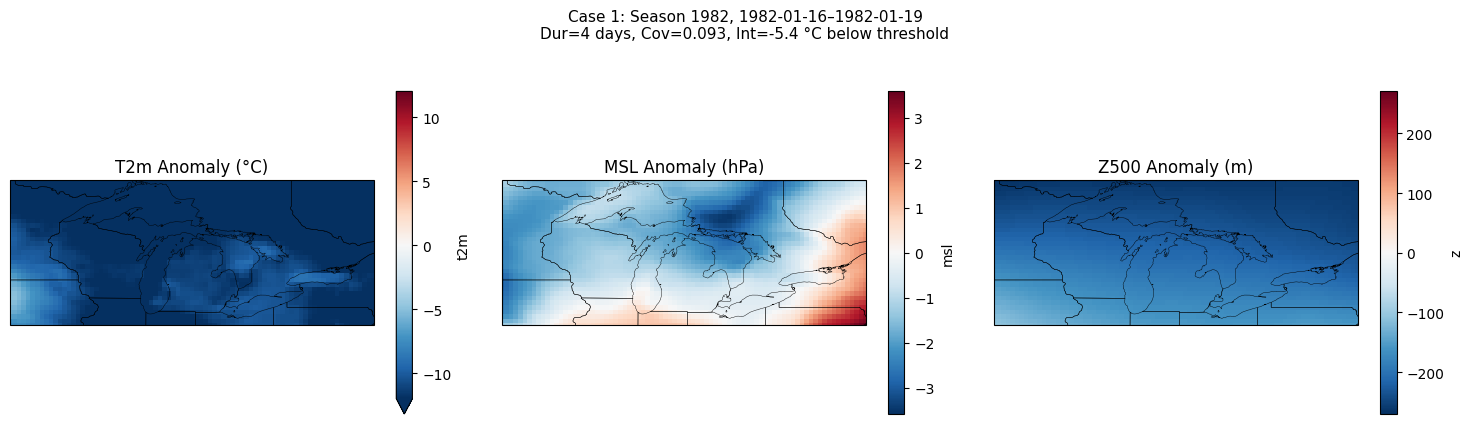

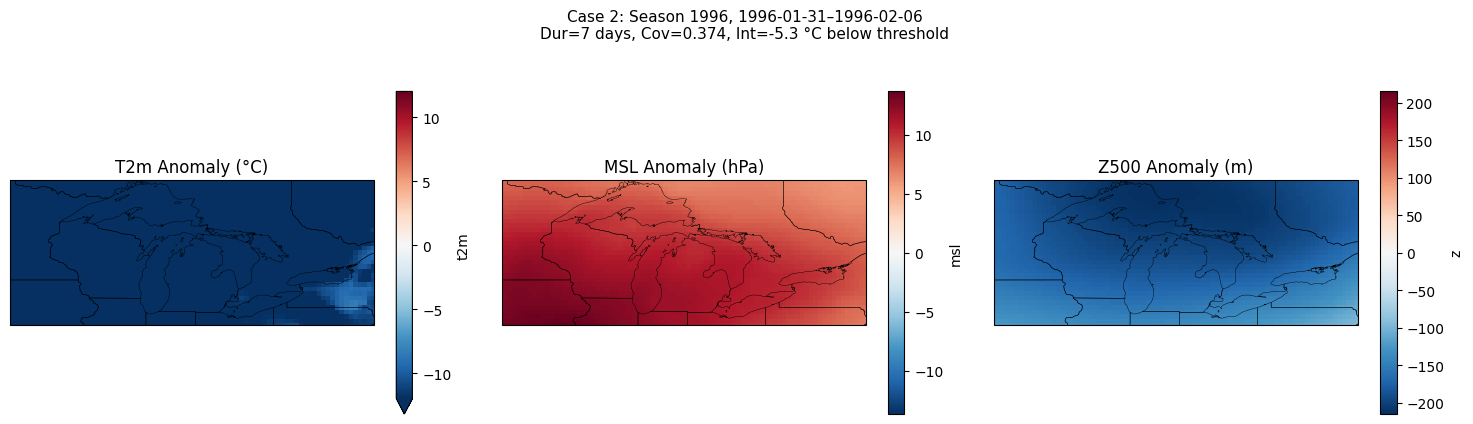

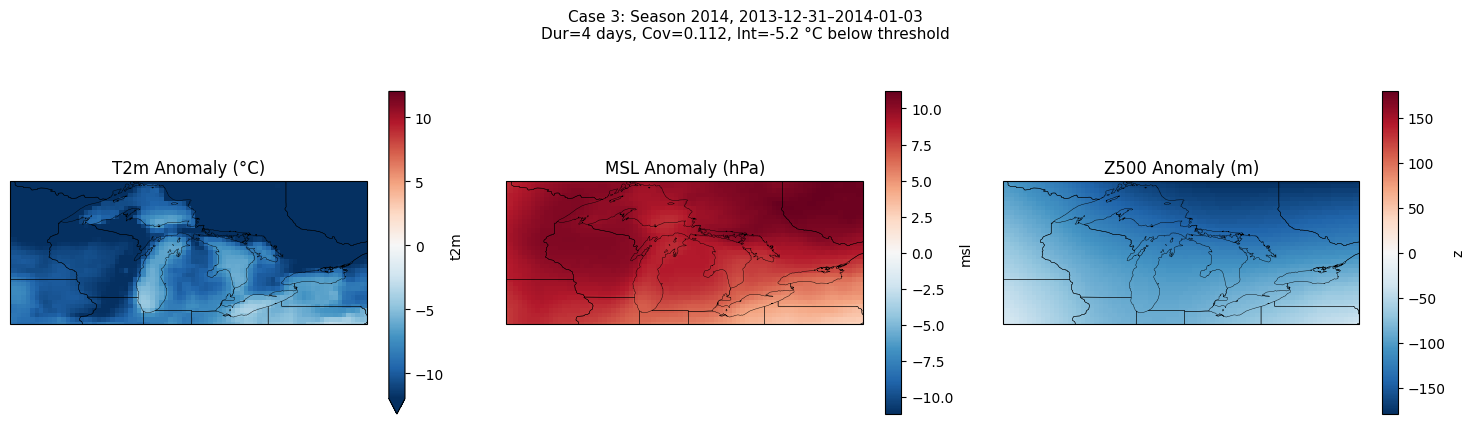

In [ ]:
# Multi-panel composites for each case study event

for j, (idx, row) in enumerate(case_events.iterrows(), start=1):
    sy = row["season_year"]
    start = row["start"]
    end = row["end"]

    # Boolean masks for event days
    mask_t2m = (
        (t2m_djf_anom["time"] >= np.datetime64(start)) &
        (t2m_djf_anom["time"] <= np.datetime64(end))
    )
    mask_msl = (
        (msl_djf_anom["time"] >= np.datetime64(start)) &
        (msl_djf_anom["time"] <= np.datetime64(end))
    )
    mask_z500 = (
        (z500_djf_anom["time"] >= np.datetime64(start)) &
        (z500_djf_anom["time"] <= np.datetime64(end))
    )

    t2m_case = t2m_djf_anom.sel(time=mask_t2m).mean("time")
    msl_case = msl_djf_anom.sel(time=mask_msl).mean("time")
    z500_case = z500_djf_anom.sel(time=mask_z500).mean("time")

    fig, axes = plt.subplots(
        1, 3, figsize=(15, 4),
        subplot_kw={"projection": ccrs.PlateCarree()}
    )

    # Common extent
    for ax in axes:
        ax.set_extent([-95, -75, 41, 49])
        ax.coastlines()
        ax.add_feature(cfeature.STATES, linewidth=0.3)

    # temperature anomaly
    im0 = t2m_case.plot(
        ax=axes[0],
        transform=ccrs.PlateCarree(),
        cmap="RdBu_r",
        vmin=-12, vmax=12,
        add_colorbar=True,
    )
    axes[0].set_title("T2m Anomaly (°C)")

    # MSL anomaly
    im1 = msl_case.plot(
        ax=axes[1],
        transform=ccrs.PlateCarree(),
        cmap="RdBu_r",
        center=0.0,
        add_colorbar=True,
    )
    axes[1].set_title("MSL Anomaly (hPa)")

    # Z500 anomaly
    im2 = z500_case.plot(
        ax=axes[2],
        transform=ccrs.PlateCarree(),
        cmap="RdBu_r",
        center=0.0,
        add_colorbar=True,
    )
    axes[2].set_title("Z500 Anomaly (m)")

    fig.suptitle(
        f"Case {j}: Season {sy}, {pd.to_datetime(start).date()}–{pd.to_datetime(end).date()}\n"
        f"Dur={row['duration_days']} days, Cov={row['regional_coverage_mean']:.3f}, "
        f"Int={row['mean_temp_below_thr']:.1f} °C below threshold",
        y=1.05,
        fontsize=11,
    )
    plt.tight_layout()
    plt.savefig("code/figures/case_study_composites.png",dpi=300,bbox_inches="tight")
    plt.show()


## Arctic Amplification

Loaded t2m_global: (1020, 721, 1440) K
Coords: ['number', 'valid_time', 'latitude', 'longitude', 'expver']
Seasonal DJF t2m shape: (86, 721, 1440)
Sample Arctic DJF temps:
 season_year
1940    250.704759
1941    250.354450
1942    251.447710
1943    250.915367
1944    252.067274
Name: T_Arctic_DJF, dtype: float64
Sample Midlat DJF temps:
 season_year
1940    272.194549
1941    273.547899
1942    272.993016
1943    273.567016
1944    274.329683
Name: T_MidLat_DJF, dtype: float64


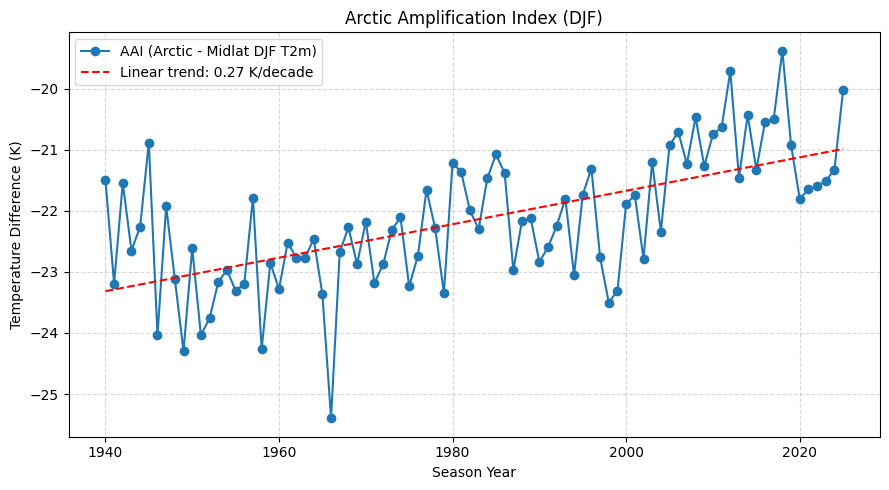

AAI trend ≈ 0.27 K/decade over 1940-2025


In [ ]:
# Arctic Amplification Index (AAI) 

# Load global ERA5 monthly-mean t2m 
era5_t2m_path = "data/era5_t2m_global_monthly_1940_2024.nc"

# open as xr dataset
ds = xr.open_dataset(era5_t2m_path)
t2m_global = ds["t2m"]  

# print
print("Loaded t2m_global:", t2m_global.shape, t2m_global.attrs.get("units", ""))
print("Coords:", list(t2m_global.coords))

# rename time
if "time" in t2m_global.coords:
    time_coord_name = "time"
elif "valid_time" in t2m_global.coords:
    time_coord_name = "valid_time"

time = t2m_global[time_coord_name]

# Extract DJF months and assign season_year

# DJF mask 
is_djf = time.dt.month.isin([12, 1, 2])

# Subset DJF months
t2m_djf = t2m_global.where(is_djf, drop=True)
time_djf = time.where(is_djf, drop=True)

# Season year
season_year = time_djf.dt.year + (time_djf.dt.month == 12).astype(int)

t2m_djf = t2m_djf.assign_coords(season_year=(time_coord_name, season_year.data))

# Compute DJF seasonal means 
t2m_djf_seasonal = t2m_djf.groupby("season_year").mean(time_coord_name)

print("Seasonal DJF t2m shape:", t2m_djf_seasonal.shape)

# Area-weighted means for Arctic and midlat bands

lat_glob = t2m_djf_seasonal.latitude
weights_glob = np.cos(np.deg2rad(lat_glob))
weights_glob = weights_glob / weights_glob.mean() 

def band_mean(da, lat_min, lat_max):
    band = da.sel(latitude=slice(lat_max, lat_min))  
    w = weights_glob.sel(latitude=band.latitude)
    return band.weighted(w).mean(dim=("latitude", "longitude"))

# Arctic: 60–90N 
# Midlatitudes: 30–60N
t_arctic = band_mean(t2m_djf_seasonal, lat_min=60, lat_max=90)   
t_midlat = band_mean(t2m_djf_seasonal, lat_min=30, lat_max=60)   

# Convert to Series
t_arctic = t_arctic.to_pandas().rename("T_Arctic_DJF")
t_midlat = t_midlat.to_pandas().rename("T_MidLat_DJF")

print("Sample Arctic DJF temps:\n", t_arctic.head())
print("Sample Midlat DJF temps:\n", t_midlat.head())

# Arctic Amplification Index (AAI)  trend plot
aai = (t_arctic - t_midlat)
aai.name = "AAI_DJF"  

# linear trend, convert K/year to K/decade
years = aai.index.values.astype(float)
slope, intercept = np.polyfit(years, aai.values, 1)  
slope_decade = slope * 10.0

plt.figure(figsize=(9, 5))
plt.plot(aai.index, aai.values, marker="o", label="AAI (Arctic - Midlat DJF T2m)")

plt.plot(
    aai.index,
    slope * years + intercept,
    "r--",
    label=f"Linear trend: {slope_decade:.2f} K/decade"
)

plt.title("Arctic Amplification Index (DJF)")
plt.xlabel("Season Year")
plt.ylabel("Temperature Difference (K)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig("code/figures/AAI_plot.png", dpi=300, bbox_inches="tight")
plt.show()

print(f"AAI trend ≈ {slope_decade:.2f} K/decade over {int(years.min())}-{int(years.max())}")


In [ ]:
# create aai and cao df
df_aai_cao = pd.concat(
    [
        cao_events_per_season.rename("n_events"),
        cao_days_per_season.rename("cao_days"),
        mean_intensity.rename("mean_intensity"),
        aai,
    ],
    axis=1
).dropna()

# print df
print(df_aai_cao.head())

# pearson r
for var in ["n_events", "cao_days", "mean_intensity"]:
    r, p = pearsonr(df_aai_cao[var], df_aai_cao["AAI_DJF"])
    print(f"{var} vs AAI: r = {r:.3f}, p = {p:.3g}")

             n_events  cao_days  mean_intensity    AAI_DJF
season_year                                               
1940              3.0        10       -2.382961 -21.489790
1941              3.0         4       -1.688588 -23.193449
1942              5.0        15       -2.151804 -21.545306
1943              5.0        14       -1.920862 -22.651649
1944              2.0         2       -1.168450 -22.262408
n_events vs AAI: r = -0.096, p = 0.401
cao_days vs AAI: r = -0.123, p = 0.28
mean_intensity vs AAI: r = 0.049, p = 0.667


             n_events  cao_days  mean_intensity    AAI_DJF
season_year                                               
1940              3.0        10       -2.382961 -21.489790
1941              3.0         4       -1.688588 -23.193449
1942              5.0        15       -2.151804 -21.545306
1943              5.0        14       -1.920862 -22.651649
1944              2.0         2       -1.168450 -22.262408
n_events vs AAI: r = -0.096, p = 0.401
cao_days vs AAI: r = -0.123, p = 0.28
mean_intensity vs AAI: r = 0.049, p = 0.667


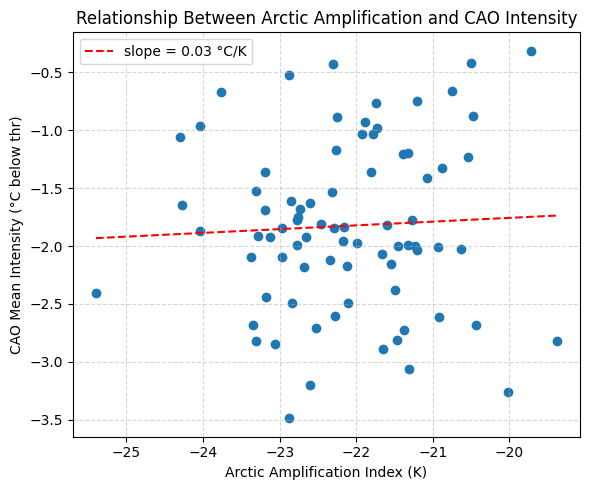

In [ ]:
#  plot AAI vs mean intensity
plt.figure(figsize=(6,5))
plt.scatter(df_aai_cao["AAI_DJF"], df_aai_cao["mean_intensity"])
m, b = np.polyfit(df_aai_cao["AAI_DJF"], df_aai_cao["mean_intensity"], 1)
xline = np.linspace(df_aai_cao["AAI_DJF"].min(), df_aai_cao["AAI_DJF"].max(), 50)
plt.plot(xline, m*xline + b, "r--", label=f"slope = {m:.2f} °C/K")

plt.xlabel("Arctic Amplification Index (K)")
plt.ylabel("CAO Mean Intensity (°C below thr)")
plt.title("Relationship Between Arctic Amplification and CAO Intensity")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig("code/figures/aai_vs_intensity.png", dpi=300, bbox_inches="tight")
plt.show()


n_events vs meridional gradient: r = -0.096, p = 0.401


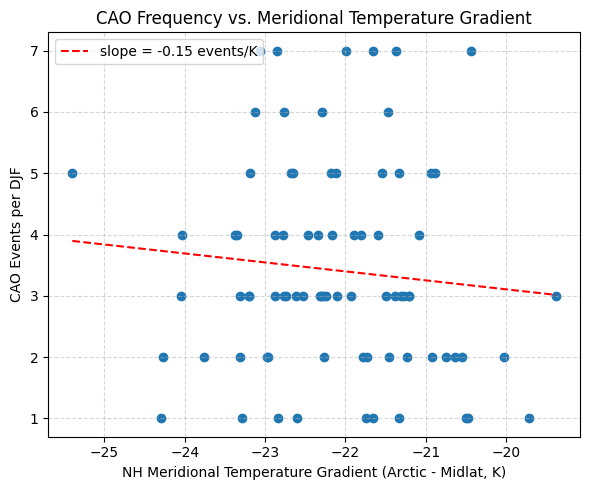

In [ ]:
# Meridional Temperature Gradient vs CAO Counts

# Great Lakes band
t_glakes = t2m_djf.sel(
    latitude=slice(lat_max, lat_min),
    longitude=slice(lon_min, lon_max)
)

# Area weights 
w_gl = np.cos(np.deg2rad(t_glakes.latitude))
w_gl = w_gl / w_gl.mean()

# Area-weighted mean 
t_glakes_mean = t_glakes.weighted(w_gl).mean(dim=("latitude", "longitude"))

time_dim = [d for d in t_glakes_mean.dims if d not in []][0]

# Seasonal mean over DJF months 
t_glakes_season = t_glakes_mean.groupby("season_year").mean(time_dim)
t_glakes_season = t_glakes_season.to_pandas().rename("T_GreatLakes_DJF")

# Meridional temperature gradient index, Arctic - Midlat
grad = (t_arctic - t_midlat)   
grad.name = "Meridional_Grad_ArcticMinusMidLat"

# Combine with CAO metrics 
df_grad_cao = pd.concat(
    [
        cao_events_per_season.rename("n_events"),
        grad,
    ],
    axis=1
).dropna()

# pearson r
r, p = pearsonr(df_grad_cao["n_events"], df_grad_cao["Meridional_Grad_ArcticMinusMidLat"])
print(f"n_events vs meridional gradient: r = {r:.3f}, p = {p:.3g}")

# Scatter plot
plt.figure(figsize=(6, 5))
x = df_grad_cao["Meridional_Grad_ArcticMinusMidLat"]
y = df_grad_cao["n_events"]

plt.scatter(x, y)
m, b = np.polyfit(x.values, y.values, 1)
xline = np.linspace(x.min(), x.max(), 50)
plt.plot(xline, m * xline + b, "r--", label=f"slope = {m:.2f} events/K")

plt.xlabel("NH Meridional Temperature Gradient (Arctic - Midlat, K)")
plt.ylabel("CAO Events per DJF")
plt.title("CAO Frequency vs. Meridional Temperature Gradient")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig("code/figures/meridional_cao_plot.png", dpi=300, bbox_inches="tight")
plt.show()
